<img typeof="foaf:Image" src="indata/ANTI-INFECTIVES-RGB_200pc.png" alt="Wellcome Centre for Anti-Infectives Research" title="">

# Analysis of Protein Turnover in <i>T. brucei</i>

Michele Tinti

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee


# Setting up

In [1]:
#import library
from tqdm import tqdm_notebook
#computing
import os
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

#plotting
import matplotlib.pyplot as plt
import matplotlib
#some ad-hoc scripts
from utilities.utilities import print_result, clean_id, clean
import warnings
import pickle
#exponential decay fit
def exp_dec_model(x, N0, tau, offset):
    return N0 * np.exp( - x / tau ) + offset

#liner fitting function
def lin_fit(x, slope, intercept):
    return intercept + x*slope


plt.style.use('ggplot')
#import pyvenny
current_palette = sns.color_palette()
sns.palplot(current_palette)

def grab(indata):
    temp_id = None
    temp_desc = None
    for item in indata.split(';'):
        if 'ID' in item:
            temp_id = item.split('=')[1]
        if 'description' in item:
            temp_desc = item.split('=')[1].replace('%2C','')
    
    return temp_id, temp_desc
    
with open('ids_dict_bsf.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ids_dict = pickle.load(f)


gff = pd.read_table('indata/genome/TriTrypDB-41_TbruceiTREU927.gff', header=None)
desc_diz = {}
for n in gff.iloc[:,-1]:
    temp = grab(n)
    desc_diz[temp[0]]=temp[1]

#test
for item in ids_dict['Tb927.5.4450']:
    print (item, desc_diz[item] )


/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


Tb927.5.4450 hypothetical protein conserved
Tb05.5K5.100 hypothetical protein conserved


# Table of Content

* [Figure 2](#Figure-2)
* [Figure 3](#Figure-3)
* [Figure 4](#Figure-4)
* [Figure 5](#Figure-5)
* [Figure 6](#Figure-6)
* [Figure 7](#Figure-7)
* [Figure 8](#Figure-8)

## Analysis Start
This is the forth notebook for the analysis of the protein turnover in T. brucei. In here we produce the figures used for the paper.
### Setting up
<ul>
    <li>Make sure to run Analysis_BSF, Analysis_PCF and Curve_fit first
    </li>    
</ul> 

# Figure 2
BSF Correletion Coefficent Analysis

[Back to content](#Table-of-Content) 

/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  app.launch_new_instance()


(6456, 630)
removed  84 Only identified by site
tot  84  entries removed
---------------
removed  63 Reverse
tot  147  entries removed
---------------
removed  134 Potential contaminant
tot  281  entries removed
---------------
removed  152 Peptide counts (all)
tot  433  entries removed
---------------


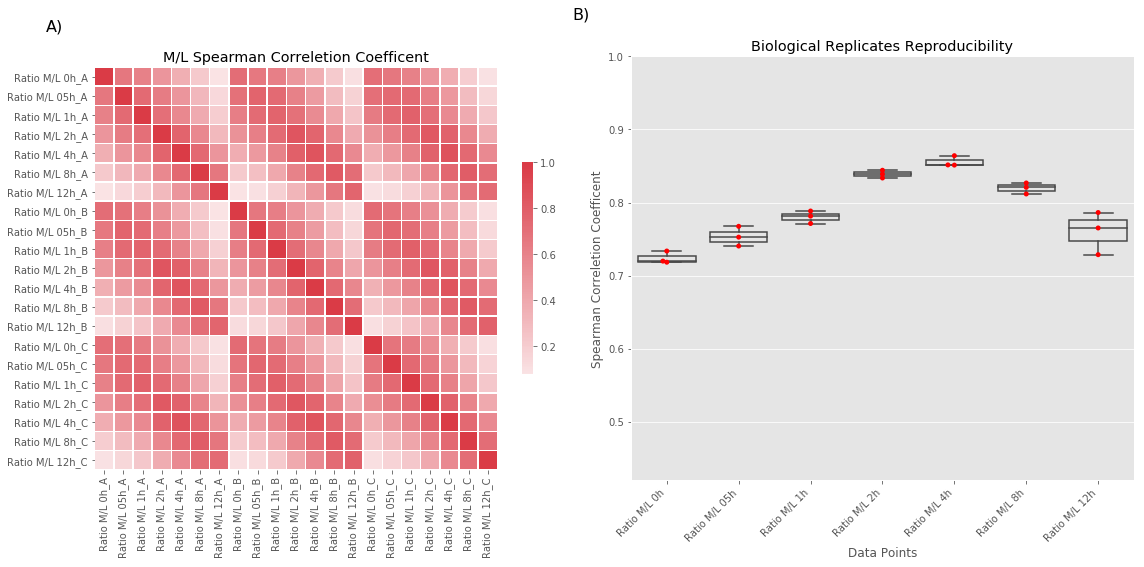

In [2]:
#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

#set some variable to extract the data
#3 biological replicates
_TAG_REPLICA=['_A' , '_B', '_C']

#7 time points for BS
#these are the headers
_TAG=['0h', '05h','1h','2h','4h','8h','12h']


#read the dataset
df= pd.read_table(os.path.join('indata','combined_noreq_bs','txt','proteinGroups.txt'), low_memory=False)

df=clean(df)
#for simplicity lets just work with the leading protein
df['protein_id']=[clean_id(n) for n in df['Protein IDs']]
df.set_index('protein_id', inplace=True)

cols3 = [ 'Ratio M/L {tp}{rep}'.format(tp=tp, rep=rep) for rep in _TAG_REPLICA for tp in _TAG]
data3 = df[cols3]
data3= data3[data3.isna().sum(axis=1)<21]


fig,axes = plt.subplots(figsize=(16,8),ncols=2,nrows=1)

plt.style.use('ggplot')
#corr = data1.fillna(data1.median()).corr()
corr = data3.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#corr[corr<0.3]=0
sns.heatmap(corr,  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[0])
           #mask=mask,)
axes[0].set_title('M/L Spearman Correletion Coefficent')

temp_list = []
mask = np.tril(np.ones_like(corr, dtype=np.bool), k=-1)
corr = corr.where(mask)
for n in range(7):
    cols = cols3[n::7]
    temp = corr.loc[cols][cols].unstack().dropna()
    temp = pd.Series(temp.values).to_frame()
    temp.columns = ['median']
    temp['data_point'] = cols3[n].split('_')[0]
    temp_list.append(temp)
temp_list=pd.concat(temp_list)
temp_list.head()
sns.boxplot(x="data_point", y="median", data=temp_list, zorder=.5,boxprops={'facecolor':'None'},ax=axes[1])
sns.swarmplot(x="data_point", y="median", data=temp_list, ax=axes[1], color='red')

axes[1].set_ylim(0.42,1)
for label in axes[1].get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
axes[1].set_xlabel('Data Points')
axes[1].set_ylabel('Spearman Correletion Coefficent')
axes[1].set_title('Biological Replicates Reproducibility')
axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)
axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[0].transAxes,fontsize=16)

plt.tight_layout()
fig.savefig(os.path.join('Figure','Figure_2.svg'))
fig.savefig(os.path.join('Figure','Figure_2.png'))

# Figure 3
PCF Correletion Coefficent Analysis

[Back to content](#Table-of-Content) 

/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if sys.path[0] == '':


(6466, 790)
removed  189 Only identified by site
tot  189  entries removed
---------------
removed  62 Reverse
tot  251  entries removed
---------------
removed  114 Potential contaminant
tot  365  entries removed
---------------
removed  206 Peptide counts (all)
tot  571  entries removed
---------------


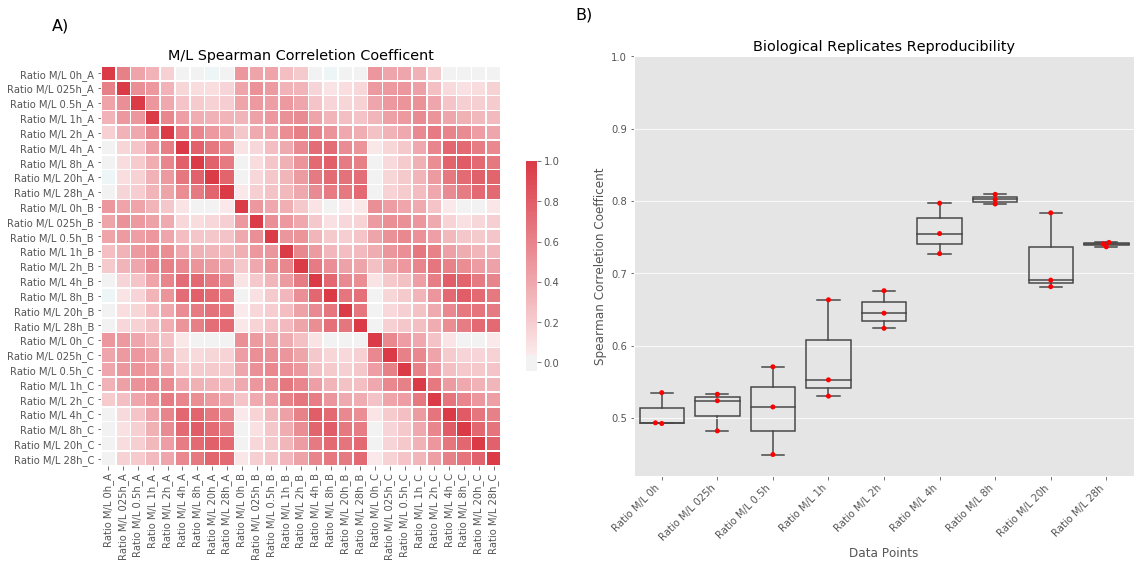

In [3]:
#set some variable to extract the data
#3 biological replicates
_TAG_REPLICA=['_A' , '_B', '_C']

#9 time points for PCF
#these are the headers
_TAG=['0h','025h','0.5h','1h', '2h','4h','8h','20h','28h' ]



#read the dataset
df= pd.read_table(os.path.join('indata','combined_noreq_pc','txt','proteinGroups.txt'), low_memory=False)
df=clean(df)
#for simplicity lets just work with the leading protein
df['protein_id']=[clean_id(n) for n in df['Protein IDs']]
df.set_index('protein_id', inplace=True)




cols3 = [ 'Ratio M/L {tp}{rep}'.format(tp=tp, rep=rep) for rep in _TAG_REPLICA for tp in _TAG]
data3 = df[cols3]
data3= data3[data3.isna().sum(axis=1)<27]



fig,axes = plt.subplots(figsize=(16,8),ncols=2,nrows=1)

plt.style.use('ggplot')
#corr = data1.fillna(data1.median()).corr()
corr = data3.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#corr[corr<0.3]=0
sns.heatmap(corr,  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[0])
           #mask=mask,)
axes[0].set_title('M/L Spearman Correletion Coefficent')

temp_list = []
mask = np.tril(np.ones_like(corr, dtype=np.bool), k=-1)
corr = corr.where(mask)
for n in range(9):
    cols = cols3[n::9]
    temp = corr.loc[cols][cols].unstack().dropna()
    temp = pd.Series(temp.values).to_frame()
    temp.columns = ['median']
    temp['data_point'] = cols3[n].split('_')[0]
    temp_list.append(temp)
temp_list=pd.concat(temp_list)
temp_list.head()

sns.boxplot(x="data_point", y="median", data=temp_list, zorder=.5,boxprops={'facecolor':'None'},ax=axes[1])
sns.swarmplot(x="data_point", y="median", data=temp_list, ax=axes[1], color='red')

#sns.swarmplot(x='data_point', y='median',ax=axes[1],data=temp_list)
axes[1].set_ylim(0.42,1)
for label in axes[1].get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
axes[1].set_xlabel('Data Points')
axes[1].set_ylabel('Spearman Correletion Coefficent')
axes[1].set_title('Biological Replicates Reproducibility')
axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)
axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[0].transAxes,fontsize=16)

plt.tight_layout()
fig.savefig(os.path.join('Figure','Figure_3.svg'))
fig.savefig(os.path.join('Figure','Figure_3.png'))

# Figure 6
Parasite Growth Curves

[Back to content](#Table-of-Content) 

/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


   Hours BSF  Replica A  Replica B  Replica C
3        2.0     620000     620000     620000
4        4.0     680000     680000     680000
5        8.0     900000     900000     910000
6       12.0    1300000    1200000    1300000
   Hours PCF  Replica A  Replica B  Replica C
5        4.0   11000000   11000000   12000000
6        6.0   12000000   12000000   12000000
7       20.0   18000000   18000000   18000000
8       28.0   24000000   25000000   24000000
[5.11727329e+05 7.46730023e-02]
bsf_h_db_time 8.000115778359042
bsf_db_time 11.852673778835182
pcf_h_db_time 13.302045806601715
pcf_db_time 22.27278235247307


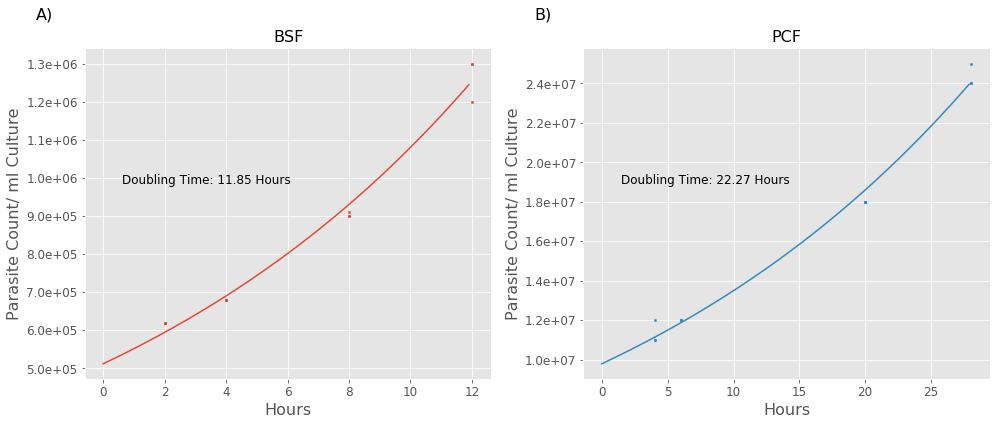

In [4]:
from scipy.optimize import curve_fit
import matplotlib as mpl
growth_bsf = pd.read_table('indata/count_bsf.txt')

growth_bsf=growth_bsf.iloc[3:]
growth_pcf = pd.read_table('indata/count_pcf.txt')
growth_pcf=growth_pcf.iloc[5:]
print(growth_bsf.head(10))
print(growth_pcf.head(10))

import matplotlib.pyplot as plt
#from matplotlib import rc
#rc('text', usetex=True)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,6))
#plt.ticklabel_format(axis='y', style='sci')


growth_bsf.plot(kind='Scatter',x='Hours BSF', y='Replica A',ax=ax[0],marker='.',color=current_palette[0])
growth_bsf.plot(kind='Scatter',x='Hours BSF', y='Replica B',ax=ax[0],marker='.',color=current_palette[0])
growth_bsf.plot(kind='Scatter',x='Hours BSF', y='Replica C',ax=ax[0],marker='.',color=current_palette[0])

x = np.array(list(growth_bsf['Hours BSF'])*3)
y=list(growth_bsf['Replica A'])+list(growth_bsf['Replica B'])+list(growth_bsf['Replica C'])

#def model(x, a, b, c):
#    return a*np.exp(-b*x)+c
def model(x, a, b):
    return a*np.exp(b*x)


popt, pcov = curve_fit(model, x, y)
print(popt)

bsf_h_db_time = (np.log(620000 +(620000*0.5) ) - np.log(popt[0]))/ popt[1]
print( 'bsf_h_db_time',bsf_h_db_time )
bsf_db_time = (np.log(620000 +620000) - np.log(popt[0]))/ popt[1]
print('bsf_db_time',bsf_db_time  )


x=np.arange(0,12,0.1)
y = [model(n,*popt) for n in x]
ax[0].plot(x,y,c=current_palette[0])

ax[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=ax[0].transAxes,fontsize=16)

ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))
ax[0].set_ylabel('Count',fontsize=16)
ax[0].set_xlabel('Hours',fontsize=16)
ax[0].set_title('BSF',fontsize=16)

ax[0].text(0.3, 0.6, 'Doubling Time: {0:.2f} Hours'.format(bsf_db_time,2), horizontalalignment='center', 
               verticalalignment='center', 
               transform=ax[0].transAxes,fontsize=12)






growth_pcf.plot(kind='Scatter',x='Hours PCF', y='Replica A',ax=ax[1],marker='.',color=current_palette[1])
growth_pcf.plot(kind='Scatter',x='Hours PCF', y='Replica B',ax=ax[1],marker='.',color=current_palette[1])
growth_pcf.plot(kind='Scatter',x='Hours PCF', y='Replica C',ax=ax[1],marker='.',color=current_palette[1])

x = np.array(list(growth_pcf['Hours PCF'])*3)
y=list(growth_pcf['Replica A'])+list(growth_pcf['Replica B'])+list(growth_pcf['Replica C'])
popt, pcov = curve_fit(model, x, y)


pcf_h_db_time = (np.log(10000000 +(10000000*0.5) ) - np.log(popt[0]))/ popt[1]
print('pcf_h_db_time', pcf_h_db_time )
pcf_db_time = (np.log(10000000 +10000000) - np.log(popt[0]))/ popt[1]
print('pcf_db_time', pcf_db_time)

ax[1].text(0.3, 0.6, 'Doubling Time: {0:.2f} Hours'.format(pcf_db_time,2), horizontalalignment='center', 
               verticalalignment='center', 
               transform=ax[1].transAxes,fontsize=12)

x=np.arange(0, 28,0.1)
y = [model(n,*popt) for n in x]
ax[1].plot(x,y,c=current_palette[1])
ax[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))
ax[1].set_ylabel('Parasite Count/ ml Culture',fontsize=16)
ax[0].set_ylabel('Parasite Count/ ml Culture',fontsize=16)
ax[1].set_xlabel('Hours',fontsize=16)
ax[1].set_title('PCF',fontsize=16)
ax[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=ax[1].transAxes,fontsize=16)
#ax[0].yaxis.major.formatter._useMathText = True
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)

#
#ax[0].Axes.ticklabel_format(style='sci', axis='y')
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
#ax[1].yaxis.major.formatter._useMathText = True
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))


fig.subplots_adjust(wspace=0.5)
plt.tight_layout()
fig.savefig(os.path.join('Figure','Figure_6.svg'))
fig.savefig(os.path.join('Figure','Figure_6.png'))

In [5]:
#index_col=['protein_id']
bsf_data = pd.read_csv(os.path.join('outdata','data_BSF.csv'))
pcf_data = pd.read_csv(os.path.join('outdata','data_PCF.csv'))
bsf_data.drop_duplicates(subset='protein_id',inplace=True)
pcf_data.drop_duplicates(subset='protein_id',inplace=True)
bsf_data.set_index('protein_id',inplace=True)
pcf_data.set_index('protein_id',inplace=True)

In [6]:
bsf_data.head()

,0h_A,05h_A,1h_A,2h_A,4h_A,8h_A,12h_A,0h_B,05h_B,1h_B,...,4h_B,8h_B,12h_B,0h_C,05h_C,1h_C,2h_C,4h_C,8h_C,12h_C
protein_id,,,,,,,,,,,,,,,,,,,,,
Tb04.24M18.150,NaN,0.798932,NaN,0.483426,0.420648,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.5.4450,NaN,0.921368,0.720377,0.830568,0.665113,0.429748,0.170499,NaN,0.922198,NaN,...,0.618335,0.369340,0.157660,NaN,NaN,NaN,0.734280,0.546403,0.311116,0.116054
Tb927.5.4460,0.963234,0.905850,0.884178,0.813065,0.644687,0.381774,0.243727,0.943307,0.933602,0.896085,...,0.630973,0.386476,0.227201,0.931520,0.924008,0.876607,0.795228,0.642655,0.395169,0.212608
Tb927.5.4470,NaN,0.826359,0.857143,0.796103,0.560330,0.401305,0.330977,NaN,0.872280,0.883049,...,0.611830,0.386643,0.252726,NaN,0.899392,0.843847,0.789909,0.583053,0.394115,0.287123
Tb927.5.4480,1.008286,0.995069,0.944232,0.888709,0.700682,0.446654,0.270179,1.024706,0.953290,0.962790,...,0.713562,0.433284,0.276344,0.989257,0.976796,0.951932,0.890329,0.721817,0.436291,0.268575


In [7]:
pcf_data.head()

,0h_A,025h_A,0.5h_A,1h_A,2h_A,4h_A,8h_A,20h_A,28h_A,0h_B,...,28h_B,0h_C,025h_C,0.5h_C,1h_C,2h_C,4h_C,8h_C,20h_C,28h_C
protein_id,,,,,,,,,,,,,,,,,,,,,
Tb927.5.4450,NaN,NaN,NaN,NaN,NaN,0.806257,0.613254,0.363577,0.294020,NaN,...,0.258285,NaN,NaN,NaN,0.969097,0.932706,0.804186,0.651418,0.389308,0.282735
Tb927.5.4460,NaN,NaN,0.920623,NaN,0.927513,0.881835,0.767122,0.435937,0.331637,NaN,...,0.311502,0.938502,0.938015,NaN,0.972545,0.959288,0.841176,0.746439,0.442146,0.310078
Tb927.5.4470,NaN,NaN,NaN,NaN,0.850046,0.718234,0.526867,0.284066,0.145569,NaN,...,0.208142,NaN,NaN,0.757162,NaN,0.880486,0.739012,0.531159,NaN,0.291859
Tb927.5.4480,0.940893,0.907011,0.904121,0.939990,0.896921,0.807715,0.701846,0.426154,0.325024,0.939002,...,0.317768,0.938984,0.915895,0.906684,0.899439,0.854198,0.823202,0.675715,0.389552,0.304305
Tb927.5.4500,0.946735,0.931802,0.929127,0.917865,0.871949,0.771979,0.627461,0.360660,0.301985,0.946252,...,0.257409,0.946010,0.926772,0.927732,0.917921,0.886602,0.808561,0.615278,0.390830,0.285595


In [8]:
bsf_fit =  pd.read_csv(os.path.join('outdata','fit_BSF.csv'))
pcf_fit = pd.read_csv(os.path.join('outdata','fit_PCF.csv'))
bsf_fit.drop_duplicates(subset='protein_id',inplace=True)
pcf_fit.drop_duplicates(subset='protein_id',inplace=True)
bsf_fit.set_index('protein_id',inplace=True)
pcf_fit.set_index('protein_id',inplace=True)

In [9]:
bsf_fit.head()

,quality,amplitude,amplitude_err,tau,tau_err,offset,offset_err,exp_half_life,exp_chisqr,exp_redchi,...,lin_half_life,lin_chisqr,lin_redchi,lin_aic,lin_bic,lin_mse,lin_mae,lin_r2,lin_rmse,linear_is_better
protein_id,,,,,,,,,,,,,,,,,,,,,
Tb927.5.4450,1,0.992687,NaN,6.747620,NaN,5.206865e-09,NaN,9.734758,6.414175,3.207087,...,6.922635,3.912616,1.304205,2.773842,1.992718,0.001622,0.031524,0.979425,0.040273,True
Tb927.5.4460,1,0.990636,NaN,8.566438,NaN,3.554046e-12,NaN,12.358758,37.611511,9.402878,...,7.374582,131.692869,26.338574,24.541936,24.433756,0.001060,0.031464,0.984764,0.032561,False
Tb927.5.4470,1,0.980738,0.16058,8.548922,3.146886,1.249686e-02,0.19224,12.333487,13.729833,4.576611,...,7.307382,64.395913,16.098978,18.239744,17.823263,0.003037,0.039005,0.943532,0.055108,False
Tb927.5.4480,1,1.116910,NaN,8.722771,NaN,1.396261e-11,NaN,12.584298,123.255752,30.813938,...,7.978253,203.138044,40.627609,27.575829,27.467650,0.001089,0.022493,0.984883,0.032994,False
Tb927.5.4500,1,0.976313,NaN,10.346422,NaN,2.668476e-09,NaN,14.926732,1590.255428,397.563857,...,7.303338,528.488029,105.697606,34.268770,34.160590,0.001830,0.040146,0.977165,0.042773,True


In [10]:
pcf_fit.head()

,quality,amplitude,amplitude_err,tau,tau_err,offset,offset_err,exp_half_life,exp_chisqr,exp_redchi,...,lin_half_life,lin_chisqr,lin_redchi,lin_aic,lin_bic,lin_mse,lin_mae,lin_r2,lin_rmse,linear_is_better
protein_id,,,,,,,,,,,,,,,,,,,,,
Tb927.5.4450,1,0.877547,0.053321,14.050688,2.130838,1.565229e-01,0.058584,20.270859,7.822655,2.607552,...,17.510562,144.372449,36.093112,23.083822,22.667341,0.005775,0.061990,0.916882,0.075995,False
Tb927.5.4460,1,1.005836,NaN,26.249237,NaN,8.356236e-10,NaN,37.869644,152.932545,38.233136,...,19.075557,107.386957,21.477391,23.113700,23.005520,0.001219,0.025822,0.979142,0.034915,True
Tb927.5.4470,1,0.866133,0.010581,9.048995,0.258182,1.724586e-01,0.013118,13.054940,0.027144,0.027144,...,10.063407,117.574707,58.787353,17.523118,16.295707,0.079794,0.164086,-0.333385,0.114051,False
Tb927.5.4480,1,0.873750,0.070939,22.269790,2.233411,6.493695e-02,0.071090,32.128515,35.588728,5.931455,...,14.994480,1121.425211,160.203602,47.426180,47.820629,0.008403,0.048726,0.829325,0.091669,False
Tb927.5.4500,1,0.903224,0.121942,19.933726,4.055969,4.314657e-02,0.122004,28.758288,32.155918,5.359320,...,16.535983,193.330606,27.618658,31.604594,31.999043,0.003335,0.035113,0.943274,0.057748,False


## Half Life correction

In [11]:
bsf_data = bsf_data.join(bsf_fit,how='left')
pcf_data = pcf_data.join(pcf_fit,how='left')


bsf_data['new_tau']=1/ (1/bsf_data['tau'])-(np.log(2)/bsf_db_time)
pcf_data['new_tau']=1/ (1/pcf_data['tau'])-(np.log(2)/pcf_db_time)

bsf_data['new_half_life']=-bsf_data['new_tau']*np.log( (bsf_data['amplitude']-bsf_data['offset'])/ (bsf_data['amplitude']*2) )
pcf_data['new_half_life']=-pcf_data['new_tau']*np.log( (pcf_data['amplitude']-pcf_data['offset'])/ (pcf_data['amplitude']*2) )

import gc
del bsf_fit
del pcf_fit
gc.collect()

/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


10640

In [12]:
def grab(x):
    x=str(x).split(';')
    temp_id='none'
    temp_desc='none'
    for n in x:
        if 'ID=' in n:
            temp_id=n.replace('ID=','')
        if 'description=' in n:
            temp_desc=n.replace('description=','')
            temp_desc=temp_desc.replace('%2C',',')
    return temp_id,temp_desc
            
gff = pd.read_table('indata/genome/TriTrypDB-41_TbruceiTREU927.gff',header=None)
desc_diz = {}
for n in gff.iloc[:,-1]:
    temp = grab(n)
    desc_diz[temp[0]]=temp[1]
desc_diz['Tb427.BES40.22']='vsg'


import pickle

with open('ids_dict_bsf.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ids_dict = pickle.load(f)

bsf_data['protein_groups']=[';'.join(ids_dict[n]) for n in bsf_data.index.values]
bsf_data['desc']=[  ';'.join([desc_diz.get(m,'missing') for m in ids_dict[n]]) for n in bsf_data.index.values]

with open('ids_dict_pcf.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ids_dict = pickle.load(f)

pcf_data['protein_groups']=[';'.join(ids_dict[n]) for n in pcf_data.index.values]
pcf_data['desc']=[  ';'.join([desc_diz.get(m,'missing') for m in ids_dict[n]]) for n in pcf_data.index.values]
    




/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  del sys.path[0]


In [13]:
print(list(bsf_data.columns))
bsf_data.head()

['0h_A', '05h_A', '1h_A', '2h_A', '4h_A', '8h_A', '12h_A', '0h_B', '05h_B', '1h_B', '2h_B', '4h_B', '8h_B', '12h_B', '0h_C', '05h_C', '1h_C', '2h_C', '4h_C', '8h_C', '12h_C', 'quality', 'amplitude', 'amplitude_err', 'tau', 'tau_err', 'offset', 'offset_err', 'exp_half_life', 'exp_chisqr', 'exp_redchi', 'exp_aic', 'exp_bic', 'exp_mse', 'exp_mae', 'exp_r2', 'exp_rmse', 'slope', 'slope_err', 'intercept', 'intercept_err', 'lin_half_life', 'lin_chisqr', 'lin_redchi', 'lin_aic', 'lin_bic', 'lin_mse', 'lin_mae', 'lin_r2', 'lin_rmse', 'linear_is_better', 'new_tau', 'new_half_life', 'protein_groups', 'desc']


,0h_A,05h_A,1h_A,2h_A,4h_A,8h_A,12h_A,0h_B,05h_B,1h_B,...,lin_bic,lin_mse,lin_mae,lin_r2,lin_rmse,linear_is_better,new_tau,new_half_life,protein_groups,desc
protein_id,,,,,,,,,,,,,,,,,,,,,
Tb04.24M18.150,NaN,0.798932,NaN,0.483426,0.420648,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tb04.24M18.150,"hypothetical protein, conserved"
Tb927.5.4450,NaN,0.921368,0.720377,0.830568,0.665113,0.429748,0.170499,NaN,0.922198,NaN,...,1.992718,0.001622,0.031524,0.979425,0.040273,True,6.689140,4.636558,Tb927.5.4450;Tb05.5K5.100,"hypothetical protein, conserved;hypothetical p..."
Tb927.5.4460,0.963234,0.905850,0.884178,0.813065,0.644687,0.381774,0.243727,0.943307,0.933602,0.896085,...,24.433756,0.001060,0.031464,0.984764,0.032561,False,8.507958,5.897267,Tb927.5.4460;Tb05.5K5.110,"major vault protein, putative;major vault prot..."
Tb927.5.4470,NaN,0.826359,0.857143,0.796103,0.560330,0.401305,0.330977,NaN,0.872280,0.883049,...,17.823263,0.003037,0.039005,0.943532,0.055108,False,8.490441,5.994008,Tb927.5.4470;Tb05.5K5.120,"hypothetical protein, conserved;hypothetical p..."
Tb927.5.4480,1.008286,0.995069,0.944232,0.888709,0.700682,0.446654,0.270179,1.024706,0.953290,0.962790,...,27.467650,0.001089,0.022493,0.984883,0.032994,False,8.664291,6.005629,Tb927.5.4480;Tb05.5K5.130,"paraflagellar rod component par4, putative;par..."


# Figure 4
Quality Threshold

[Back to content](#Table-of-Content) 

In [14]:
#define threshold for fit quality
limit_rmse = 0.1

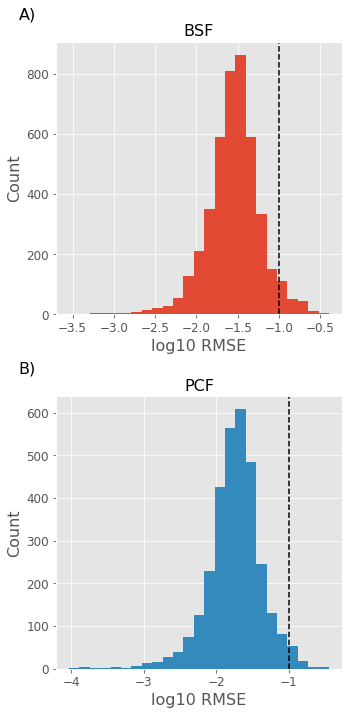

In [15]:
plt.style.use('ggplot')

fig,ax=plt.subplots(ncols=1, nrows=2,figsize=(5,10))

np.log10(bsf_data['exp_rmse'].dropna()).plot(
    kind='hist', ax=ax[0],bins=25,color=current_palette[0])


np.log10(pcf_data['exp_rmse'].dropna()).plot(
    kind='hist', ax=ax[1], bins=25, color=current_palette[1])


ax[0].axvline(np.log10(limit_rmse),color='k',linestyle='--')
ax[1].axvline(np.log10(limit_rmse),color='k',linestyle='--')
ax[0].set_title('BSF',fontsize=16)
ax[1].set_title('PCF',fontsize=16)
ax[1].set_xlabel('log10 RMSE',fontsize=16)
ax[0].set_xlabel('log10 RMSE',fontsize=16)
ax[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=ax[0].transAxes,fontsize=16)

ax[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=ax[1].transAxes,fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)


ax[0].set_ylabel('Count',fontsize=16)
ax[1].set_ylabel('Count',fontsize=16)

#fig.subplots_adjust(wspace=0.3)
#fig.subplots_adjust(hspace=0.4)
plt.tight_layout()
fig.savefig(os.path.join('Figure','Figure_4.svg'))
fig.savefig(os.path.join('Figure','Figure_4.png'))
plt.show()

In [16]:
exp_bsf = bsf_data[bsf_data['exp_rmse']<limit_rmse]
exp_pcf = pcf_data[pcf_data['exp_rmse']<limit_rmse]

print('BSF exp',exp_bsf.shape)
print('PCF exp',exp_pcf.shape)

BSF exp (4194, 55)
PCF exp (3092, 61)


In [17]:
TableBSF = bsf_data.copy()
TablePCF = pcf_data.copy()

TableBSF['used_for_analysis']=[1 if n in exp_bsf.index.values else 0 for n in TableBSF.index.values]
TablePCF['used_for_analysis']=[1 if n in exp_pcf.index.values else 0 for n in TablePCF.index.values]


In [18]:
print ('common:', len(set(exp_bsf.index.values) & set(exp_pcf.index.values)))

common: 2600


In [19]:
mean_exp_bsf = {}
for index,prot in enumerate(exp_bsf.index.values):
    #print (exp_bsf.loc[prot].iloc[:,0:7].values)
    temp = pd.DataFrame()
    temp['A']=exp_bsf.loc[prot].iloc[0:7].values
    temp['B']=exp_bsf.loc[prot].iloc[7:14].values
    temp['C']=exp_bsf.loc[prot].iloc[14:21].values
    mean_exp_bsf[prot] = temp.mean(axis=1,skipna=True)
mean_exp_bsf=pd.DataFrame.from_dict(mean_exp_bsf,orient='index')    
mean_exp_bsf.head()

,0,1,2,3,4,5,6
Tb05.5K5.210,0.964016,0.913008,0.841213,0.657129,0.466743,0.302963,0.176929
Tb05.5K5.420,0.937003,0.902853,0.850075,0.766483,0.591644,0.366439,0.197680
Tb06.3A7.960,0.916268,0.777042,0.831352,0.701383,0.571818,0.362581,0.243012
Tb07.11L3.100,NaN,0.715594,0.775812,0.715106,0.581532,0.338162,0.301555
Tb08.27P2.160,0.953341,0.969129,0.963601,0.849783,0.665919,0.353179,0.212952


In [20]:
mean_exp_pcf = {}
for index,prot in enumerate(exp_pcf.index.values):
    temp = pd.DataFrame()
    temp['A']=exp_pcf.loc[prot].iloc[0:9].values
    temp['B']=exp_pcf.loc[prot].iloc[9:18].values
    temp['C']=exp_pcf.loc[prot].iloc[18:27].values
    mean_exp_pcf[prot] = temp.mean(axis=1,skipna=True)
mean_exp_pcf=pd.DataFrame.from_dict(mean_exp_pcf,orient='index')    
mean_exp_pcf.head()

,0,1,2,3,4,5,6,7,8
Tb06.3A7.960,NaN,0.881821,0.886489,NaN,0.690715,0.676424,0.503676,0.243067,0.186663
Tb09.v4.0009,0.724072,NaN,0.752024,0.861433,0.569044,0.701373,0.620981,0.311538,0.200548
Tb09.v4.0067,0.963440,0.970845,0.963117,0.948622,0.907855,0.829409,0.691767,0.419032,0.331671
Tb10.v4.0041,NaN,0.925725,0.915645,0.897934,0.873183,0.755864,0.563580,0.298888,0.170315
Tb11.02.5070b,NaN,NaN,0.878105,0.875201,0.727500,0.436379,0.244770,0.062471,NaN


In [21]:
xp = np.array([0, 0.25, 0.5, 1, 2, 4, 8, 20, 28])/pcf_db_time
mean_exp_pcf_sns = pd.concat([mean_exp_pcf.iloc[:,n] for n in range(mean_exp_pcf.shape[1])]).to_frame()
mean_exp_pcf_sns['hours']=[ n for n in xp for a in range(mean_exp_pcf.shape[0]) ]
mean_exp_pcf_sns['stage']='PCF'
mean_exp_pcf_sns=mean_exp_pcf_sns.reset_index()
mean_exp_pcf_sns.columns = ['protein_id','value','hour','stage']
mean_exp_pcf_sns.head()

,protein_id,value,hour,stage
0,Tb06.3A7.960,NaN,0.0,PCF
1,Tb09.v4.0009,0.724072,0.0,PCF
2,Tb09.v4.0067,0.963440,0.0,PCF
3,Tb10.v4.0041,NaN,0.0,PCF
4,Tb11.02.5070b,NaN,0.0,PCF


In [22]:
xb = np.array([0, 0.5, 1, 2, 4, 8, 12])/bsf_db_time
mean_exp_bsf_sns = pd.concat([mean_exp_bsf.iloc[:,n] for n in range(mean_exp_bsf.shape[1])]).to_frame()
mean_exp_bsf_sns['hours']=[ n for n in xb for a in range(mean_exp_bsf.shape[0]) ]
mean_exp_bsf_sns['stage']='BSF'
mean_exp_bsf_sns=mean_exp_bsf_sns.reset_index()
mean_exp_bsf_sns.columns = ['protein_id','value','hour','stage']
mean_exp_bsf_sns.head()

,protein_id,value,hour,stage
0,Tb05.5K5.210,0.964016,0.0,BSF
1,Tb05.5K5.420,0.937003,0.0,BSF
2,Tb06.3A7.960,0.916268,0.0,BSF
3,Tb07.11L3.100,NaN,0.0,BSF
4,Tb08.27P2.160,0.953341,0.0,BSF


In [23]:
mean_exp_sns = pd.concat([mean_exp_bsf_sns,mean_exp_pcf_sns])
mean_exp_sns.head()

,protein_id,value,hour,stage
0,Tb05.5K5.210,0.964016,0.0,BSF
1,Tb05.5K5.420,0.937003,0.0,BSF
2,Tb06.3A7.960,0.916268,0.0,BSF
3,Tb07.11L3.100,NaN,0.0,BSF
4,Tb08.27P2.160,0.953341,0.0,BSF


In [24]:
med_bsf = (mean_exp_sns[(mean_exp_sns['hour']==0) & (mean_exp_sns['stage']=='BSF')]['value'].median())
med_pcf = (mean_exp_sns[(mean_exp_sns['hour']==0) & (mean_exp_sns['stage']=='PCF')]['value'].median())
print (med_pcf)
print (med_bsf)
print (med_pcf/med_bsf)
#mean_exp_sns[mean_exp_sns['stage']=='BSF']=mean_exp_sns[mean_exp_sns['stage']=='BSF']+med_pcf-med_bsf

0.9478592194955149
0.947256767301127
1.0006359967172411


In [25]:
mean_exp_sns[mean_exp_sns['protein_id']=='Tb05.5K5.210']

,protein_id,value,hour,stage
0,Tb05.5K5.210,0.964016,0.000000,BSF
4194,Tb05.5K5.210,0.913008,0.042185,BSF
8388,Tb05.5K5.210,0.841213,0.084369,BSF
12582,Tb05.5K5.210,0.657129,0.168738,BSF
16776,Tb05.5K5.210,0.466743,0.337477,BSF
20970,Tb05.5K5.210,0.302963,0.674953,BSF
25164,Tb05.5K5.210,0.176929,1.012430,BSF


In [26]:
def exp_dec_model(x, N0, tau, offset):
    return N0 * np.exp( - x / tau ) + offset

def plot_lines_bsf(ax):
    fit_bs = pd.read_csv(os.path.join('outdata','fit_BSF.csv'),index_col='protein_id')[['amplitude','tau','offset']]
    fit_bs = fit_bs.loc[exp_bsf.index.values]
    fit_bs.head()
    res = {}
    x =      [0.1  ,1,   2,   3,   4,    5,   6,   7,   8,   9,   10,   11,   12,   13]
    labels = ['',  '1', '2', '3', '4',  '5', '6', '7', '8', '9', '10', '11', '12', '']
    for prot in tqdm_notebook(fit_bs.index.values):
        temp = fit_bs.loc[prot]
        N0, tau, offset = temp['amplitude'],temp['tau'],temp['offset']
        values = [exp_dec_model(n, N0, tau, offset) for n in x]
        res[prot]=values

    res = pd.DataFrame.from_dict(res)
    temp_bs = res.T
    temp_bs.columns = x
    temp_bs = temp_bs[temp_bs.iloc[:,-1]<0.1]
    #print(temp.shape)
    temp_bs.T.plot(kind='line',alpha=0.01,legend=None, c=current_palette[0],ax=ax)

    temp = res.T
    temp_bs.columns = x
    temp = temp[temp.iloc[:,-1]>0.1]#.sample(100)

    temp.T.plot(kind='line',alpha=0.01,legend=None, c=current_palette[0],ax=ax)

    #res.T.sample(1000).T.plot(kind='line',alpha=0.05,legend=None, c='r')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0,1.1)

def plot_lines_pcf(ax):
    fit_pc = pd.read_csv(os.path.join('outdata','fit_PCF.csv'),
                         index_col='protein_id')[['amplitude','tau','offset']]
    fit_pc = fit_pc.loc[exp_pcf.index.values]
    fit_pc.head()
    res_pc = {}
    x =      [0.1,     2,   4,    6,     8,     10,    12,   14,   16,   18,   20,   22,   24,   26 , 28]
    labels = ['',     '2',  '4',  '6',  '8',   '10',  '12', '14', '16', '18', '20', '22', '24',  '26', '' ]
    for prot in tqdm_notebook(fit_pc.index.values):
        temp = fit_pc.loc[prot]
        N0, tau, offset = temp['amplitude'], temp['tau'], temp['offset']
        values = [exp_dec_model(n, N0, tau, offset) for n in x]
        res_pc[prot]=values

    res_pc = pd.DataFrame.from_dict(res_pc)
    temp_pc = res_pc.T
    temp_pc.columns = x
    temp_pc = temp_pc[temp_pc.iloc[:,-1]<0.1]
    #print(temp_pc.head)
    temp_pc.T.plot(kind='line',alpha=0.01,legend=None, c=current_palette[1],ax=ax)

    temp_pc = res_pc.T
    temp_pc = temp_pc[temp_pc.iloc[:,-1]>0.1]#.sample(100)
    temp_pc.columns = x
    temp_pc.T.plot(kind='line',alpha=0.01,legend=None, c=current_palette[1],ax=ax)

    #res.T.sample(1000).T.plot(kind='line',alpha=0.05,legend=None, c='r')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0,1.1)

# Figure 5
Completeness of Isotope Incorporation

[Back to content](#Table-of-Content) 

In [27]:
to_use =['K Count','R Count']+['Ratio '+ratio+' 0h_'+exp for ratio in ['M/L','H/L'] for exp in ['A','B','C']]
pep = pd.read_table(os.path.join('indata', 'combined_noreq_bs', 'txt', 'peptides.txt'), 
                    low_memory=False,usecols=to_use)
from utilities.utilities import reduce_mem_usage
pep, _ = reduce_mem_usage(pep)

/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until


Memory usage of properties dataframe is : 5.5169830322265625  MB
******************************
Column:  R Count
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  K Count
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  Ratio M/L 0h_A
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  Ratio H/L 0h_A
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  Ratio M/L 0h_B
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  Ratio H/L 0h_B
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  Ratio M/L 0h_C
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  

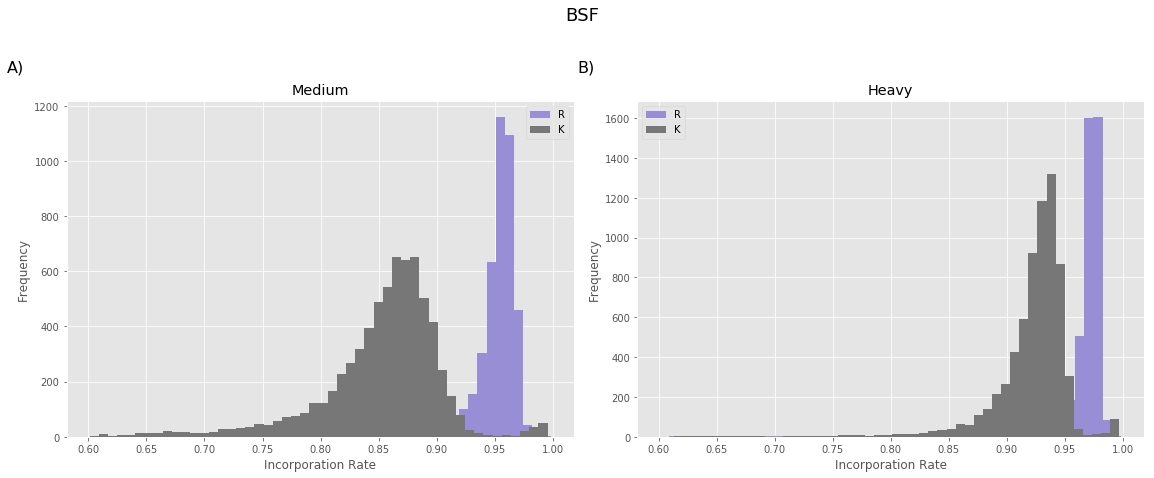

In [28]:
def plot_incorporation(pep, ratio='M/L', exp='A', ax=''):
    temp = pep[(pep['K Count']==0) & (pep['R Count']>=1)]
    #print (temp.head())
    temp = 1/temp['Ratio '+ratio+' 0h_'+exp]
    temp = 1-temp
    temp = temp[(temp>0.6)&(temp<1)]
    temp.plot(kind='hist', ax=ax, bins=50, label='R',color=current_palette[2])
    #ax[0].set_title('R')
    temp = pep[(pep['R Count']==0) & (pep['K Count']>=1)]
    temp = 1/temp['Ratio '+ratio+' 0h_'+exp]
    temp = 1-temp
    temp = temp[(temp>0.6)&(temp<1)]
    temp.plot(kind='hist',ax=ax, bins=50, label='K',color=current_palette[3])
    #ax[1].set_title('K')
    
    

fig,ax=plt.subplots(ncols=2, nrows=1,figsize=(16,6))    
plot_incorporation(pep, ratio='M/L', exp='A', ax=ax[0]) 
plot_incorporation(pep, ratio='H/L', exp='A', ax=ax[1])
ax[0].set_title('Medium')
ax[0].legend()
ax[1].set_title('Heavy')
plt.legend()
plt.suptitle('BSF', fontsize=18,y=1.1)
ax[1].set_xlabel('Incorporation Rate',fontsize=12)
ax[0].set_xlabel('Incorporation Rate',fontsize=12)

ax[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=ax[0].transAxes,fontsize=16)

ax[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=ax[1].transAxes,fontsize=16)

plt.tight_layout()
fig.savefig(os.path.join('Figure','Figure_5.svg'))
fig.savefig(os.path.join('Figure','Figure_5.png'))
plt.show()

# Figure 7
Protein Turnover of BSF and PCF Proteomes

[Back to content](#Table-of-Content) 

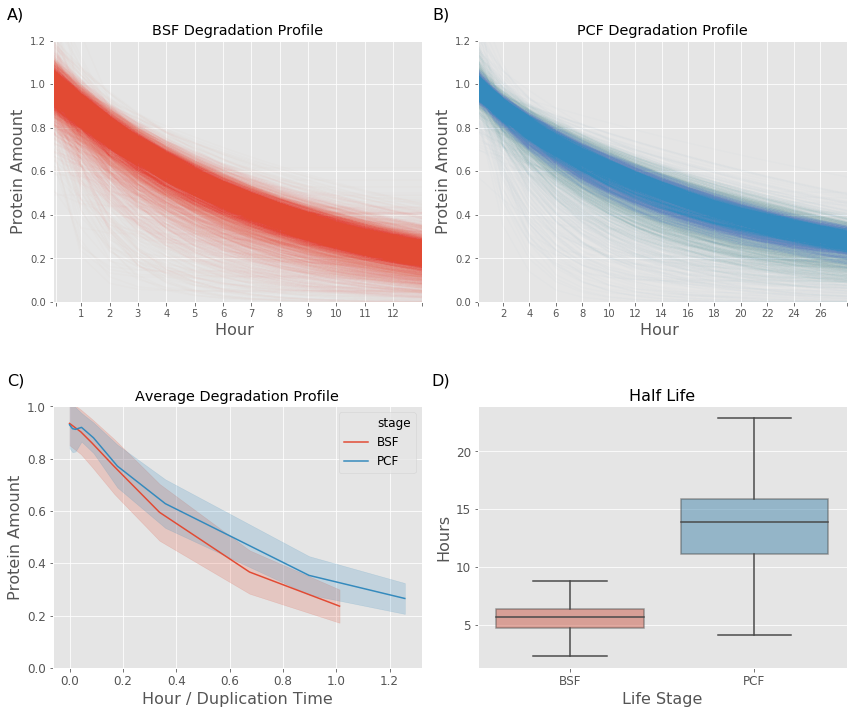

In [29]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(12, 10))


plot_lines_bsf(axes[0,0])


axes[0,0].set_ylim(0,1.2)
axes[0,0].set_title('BSF Degradation Profile')
axes[0,0].set_xlabel('Hour ',fontsize=16)
axes[0,0].set_ylabel('Protein Amount',fontsize=16)
axes[0,0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[0,0].transAxes, fontsize=16)






plot_lines_pcf(axes[0,1])

axes[0,1].set_ylim(0,1.2)
axes[0,1].set_title('PCF Degradation Profile')
axes[0,1].set_xlabel('Hour ',fontsize=16)
axes[0,1].set_ylabel('Protein Amount',fontsize=16)
axes[0,1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[0,1].transAxes, fontsize=16)






sns.lineplot(x="hour", y="value",
             hue="stage",ci='sd',
             data=mean_exp_sns,ax=axes[1,0])




axes[1,0].set_ylim(0,1)
axes[1,0].set_title('Average Degradation Profile')
axes[1,0].set_xlabel('Hour / Duplication Time',fontsize=16)
axes[1,0].set_ylabel('Protein Amount',fontsize=16)
axes[1,0].text(-0.1, 1.1, 'C)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[1,0].transAxes, fontsize=16)

#axes[1,0].legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=12)
axes[1,0].legend( fontsize=12)




temp = pd.concat([exp_bsf['new_half_life'], exp_pcf['new_half_life']],axis=1)
temp.columns = ['BSF','PCF']
sns.boxplot(data=temp, ax=axes[1,1], boxprops=dict(alpha=0.5),showfliers=False)

axes[1,1].set_title('Half Life',fontsize=16)
axes[1,1].set_ylabel('Hours',fontsize=16)
axes[1,1].set_xlabel('Life Stage',fontsize=16)
axes[1,1].text(-0.1, 1.1, 'D)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1,1].transAxes,fontsize=16)

#axes[1].legend(loc='center left', bbox_to_anchor=(1.1, 0.8), fontsize=12)



axes[1,0].tick_params(axis='both', which='major', labelsize=12)
axes[1,1].tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
fig.subplots_adjust(hspace=0.4)
plt.savefig(os.path.join('Figure','Figure_7.png'))
plt.savefig(os.path.join('Figure','Figure_7.svg'))

plt.show()

In [30]:
exp_bsf['new_half_life'].median(),exp_pcf['new_half_life'].median()

(5.663889136843346, 13.88249698157434)

In [31]:
exp_bsf['new_half_life'].median()/11.85

0.4779653280036579

In [32]:
exp_pcf['new_half_life'].median()/22.3

0.6225334969315848

# Figure 9
Correlation of Protein Half-Lives between Life-Cycle Stages

[Back to content](#Table-of-Content)

                    BSF       PCF     diffe
Tb05.5K5.210   3.927583       NaN       NaN
Tb05.5K5.420   5.766479       NaN       NaN
Tb06.3A7.960   5.583759  8.984693 -3.400934
Tb07.11L3.100  4.815196       NaN       NaN
Tb08.27P2.160  5.041276       NaN       NaN


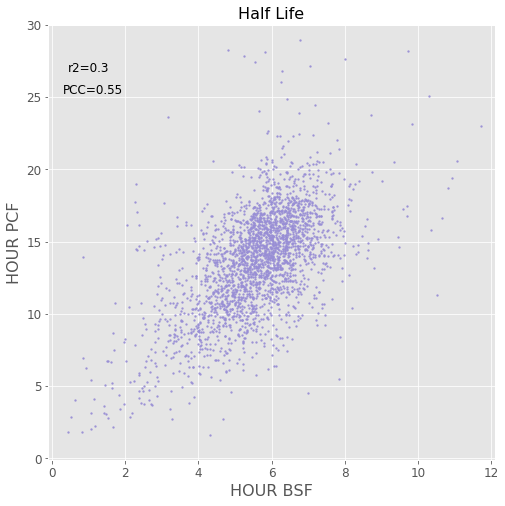

In [33]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

def r2(x, y):
    return round(stats.pearsonr(x, y)[0] ** 2, 2)
def pcc(x, y):
    return round(stats.pearsonr(x, y)[0], 2)


fig, axes = plt.subplots(ncols=1, nrows=1, figsize = (8, 8) )
temp=pd.concat([exp_bsf['new_half_life'], exp_pcf['new_half_life']], axis=1)
temp.columns=['BSF', 'PCF']
temp['diffe']=temp['BSF']-temp['PCF']
#temp['loc']=[1 if n in remove else 0 for n in temp.index.values]
temp.to_csv('erl.csv')
print (temp.head())
temp=temp.dropna()

p = sns.regplot(data=temp, x='BSF',y='PCF', ax=axes,  
                scatter_kws={'s':2} , color=current_palette[2],
                fit_reg=False
               #order=3,
                #logx=True,
               #robust=True,
               #n_boot=10
               )
#sns.regplot(data=temp[temp['loc']==0], x='BSF',y='PCF', ax=axes,  scatter_kws={'s':2} , color=current_palette[3])


#sns.jointplot(data=temp, x='BSF',y='PCF',kind="kde")
axes.set_title('Half Life',fontsize=16)
axes.text(0.09, 0.9, 'r2='+str(r2(temp['BSF'], temp['PCF'])), horizontalalignment='center', 
               verticalalignment='center', fontsize=12,
               transform=axes.transAxes)
axes.text(0.1, 0.85, 'PCC='+str(pcc(temp['BSF'], temp['PCF'])), horizontalalignment='center', 
               verticalalignment='center', fontsize=12,
               transform=axes.transAxes)


axes.set_ylabel('HOUR PCF',fontsize=16)
axes.set_xlabel('HOUR BSF',fontsize=16)
axes.tick_params(axis='both', which='major', labelsize=12)
axes.set_xlim(-0.1,12.1)
axes.set_ylim(-0.1,30)
plt.savefig(os.path.join('Figure','Figure_9.png'))
plt.savefig(os.path.join('Figure','Figure_9.svg'))
plt.show()




In [34]:
print(exp_bsf['new_half_life'].median(),)
print(exp_pcf['new_half_life'].median(),)

5.663889136843346
13.88249698157434


In [35]:
print (exp_bsf.loc['Tb927.5.360']['new_half_life'])
print (exp_bsf.loc['Tb927.2.3270']['new_half_life'])
print (exp_bsf.loc['Tb927.6.1460']['new_half_life'])
print (exp_bsf.loc['Tb927.11.14080']['new_half_life'])
print (exp_bsf.loc['Tb427.BES40.22']['new_half_life'])
print (exp_bsf.loc['Tb927.10.11030']['new_half_life'])

2.4105339588157833
2.5196861466819054
5.663999212907108
4.25405124728996
5.34639656202294
5.857398109224308


# Figure 8 
Exponential Decay Parameters

[Back to content](#Table-of-Content) 

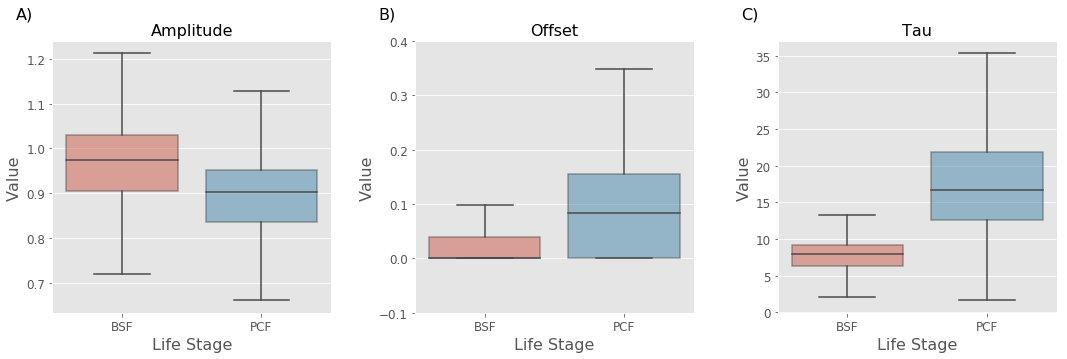

In [36]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
fig,axes=plt.subplots(ncols=3,nrows=1,figsize=(18, 5))



temp = pd.concat([exp_bsf['amplitude'], exp_pcf['amplitude']],axis=1)
temp.columns = ['BSF','PCF']
sns.boxplot(data=temp,ax=axes[0], boxprops=dict(alpha=0.5),showfliers=False)
axes[0].set_title('Amplitude',fontsize=16)
axes[0].set_ylabel('Value',fontsize=16)
axes[0].set_xlabel('Life Stage',fontsize=16)

axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[0].transAxes,fontsize=16)

#axes[0].set_ylim(-0.1,0.4)






temp = pd.concat([exp_bsf['offset'], exp_pcf['offset']],axis=1)
temp.columns = ['BSF','PCF']
sns.boxplot(data=temp,ax=axes[1], boxprops=dict(alpha=0.5),showfliers=False)
axes[1].set_title('Offset',fontsize=16)
axes[1].set_ylabel('Value',fontsize=16)
axes[1].set_xlabel('Life Stage',fontsize=16)

axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[1].transAxes,fontsize=16)

axes[1].set_ylim(-0.1,0.4)





temp = pd.concat([exp_bsf['tau'], exp_pcf['tau']],axis=1)
temp.columns = ['BSF','PCF']
#temp[temp>40]=np.nan
sns.boxplot(data=temp, ax=axes[2], boxprops=dict(alpha=0.5),showfliers=False)

axes[2].set_title('Tau',fontsize=16)
axes[2].set_ylabel('Value',fontsize=16)
axes[2].set_xlabel('Life Stage',fontsize=16)
axes[2].text(-0.1, 1.1, 'C)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[2].transAxes,fontsize=16)



axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)



#axes[2,1].axis('off')
fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.4)
#plt.suptitle('Exponential Decay',fontsize=21)
plt.savefig(os.path.join('Figure','Figure_8.png'))
plt.savefig(os.path.join('Figure','Figure_8.svg'))
plt.show()

In [37]:
import re
tm = pd.read_table(os.path.join('indata','GeneByLocusTag_TMHMM.txt'))
tm.head()
print(len(tm['[Gene ID]'].unique()))
sp = pd.read_table(os.path.join('indata','GeneByLocusTag_SignalP.txt'))
sp.head()
print(len(sp['[Gene ID]'].unique()))
remove = set(list(tm['[Gene ID]'].unique())+list(sp['[Gene ID]'].unique()))
len(remove)
mic = pd.read_table(os.path.join('indata','GeneByLocusTag_CellularLocalization.txt'))
mic.head()

prots = []
locs = []
for index,l in enumerate(open(os.path.join('indata','GeneByLocusTag_CellularLocalization.txt'))):
    #print (index,l)
    if 'C terminal tag' in l:
        loc = re.findall(string=l,pattern='image(.*?)<a') [0].split('\t')[1].strip()
        prot = re.findall(string=l, pattern='id\=(.*?)\"')[0]
        if 'GO' in loc:
            loc = loc.split(' GO')[0]
        prots.append(prot)
        locs.append(loc)

loc_df = pd.DataFrame()
loc_df['prots']=prots
loc_df['locs']=locs
loc_df=loc_df.drop_duplicates()
print (loc_df.head())
selection_loc = loc_df.locs.value_counts().sort_values().tail(30)
print(selection_loc.head(30)) 

578
552
           prots                      locs
0   Tb927.1.1020              hook complex
3   Tb927.1.1050    nucleoplasm, cytoplasm
6   Tb927.1.1170    nucleoplasm, cytoplasm
9    Tb927.1.120  nucleolus, nucleus(weak)
12  Tb927.1.1340      endocytic, cytoplasm
hook complex                                     11
paraflagellar rod                                11
cytoplasm(points), flagellar cytoplasm           12
kinetoplast(strong), mitochondrion               13
glycosome                                        14
cytoplasm(reticulated, points)                   15
nuclear pore                                     16
axoneme, cytoplasm(weak)                         16
endoplasmic reticulum, nuclear envelope          16
nucleoplasm(points)                              17
kinetoplast                                      17
axoneme, cytoplasm                               21
axoneme, cytoplasm(points)                       22
mitochondrion, kinetoplast                       28
mitoch

In [38]:
col = 'new_half_life'

def r2(x, y):
    return round(stats.pearsonr(x, y)[0] ** 2, 2)
def pcc(x, y):
    return round(stats.pearsonr(x, y)[0], 2)

In [39]:
temp=pd.concat([exp_bsf['new_half_life'], exp_pcf['new_half_life']], axis=1)
temp.columns=['BSF', 'PCF']
temp['BSFn']=(temp.BSF-temp.BSF.median())/temp.BSF.std(ddof=0)
temp['PCFn']=(temp.PCF-temp.PCF.median())/temp.PCF.std(ddof=0)

In [40]:
ref_df = pd.read_csv(os.path.join('indata','gly','glycosome_experiment_extended.txt'),sep='\t')
ref_df['[Ortholog Group]']=ref_df['[Ortholog Group]'].astype('category')
ref_df['ortho_codes']=ref_df['[Ortholog Group]'].cat.codes
ref_df['[Input ID]']=[n.replace(' ','') for n in ref_df['[Input ID]']]
ref_df.set_index('[Input ID]',inplace=True)  
#print (ref_df.head())

lucia_experiments = pd.read_table('indata/gly/glycosome_experiment.txt',sep='\t')
lucia_experiments['[Input ID]']=lucia_experiments['GeneDB IDs']
lucia_experiments['[Input ID]']=[n.replace(' ','') for n in lucia_experiments['[Input ID]']]
lucia_experiments.set_index('[Input ID]',inplace=True)
#print (lucia_experiments.head())

ref_df = ref_df.join(lucia_experiments,how='left')
ref_df['Group']=ref_df['Group'].astype('category')
ref_df['class_codes']=ref_df['Group'].cat.codes
hc_gly = ref_df[ref_df['Glycosome status ']=='green'][['[Gene ID]']]
hc_gly.head()
hc_gly['locs']='glycosome'
hc_gly.reset_index(inplace=True)
hc_gly.drop('[Input ID]',axis=1,inplace=True)
hc_gly.columns = ['prots','locs']
hc_gly.head()
print (hc_gly.shape)
loc_df = pd.concat([loc_df,hc_gly])

(159, 2)


In [41]:
temp = loc_df.join(temp, on='prots')
temp['loc_count']=[ len(str(n).split(',')) for n in temp['locs'] ]
print (temp.head())
#temp=temp.dropna()
print (temp.shape)
temp = temp[temp['loc_count']<2]
print(temp.shape)
temp['desc'] = [desc_diz[item] for item in temp.prots]
temp.head()

           prots                      locs       BSF        PCF      BSFn  \
0   Tb927.1.1020              hook complex  6.894877        NaN  0.781341   
3   Tb927.1.1050    nucleoplasm, cytoplasm  7.874194        NaN  1.402940   
6   Tb927.1.1170    nucleoplasm, cytoplasm  5.434659        NaN -0.145498   
9    Tb927.1.120  nucleolus, nucleus(weak)  6.483839  16.229754  0.520444   
12  Tb927.1.1340      endocytic, cytoplasm  4.819866        NaN -0.535724   

        PCFn  loc_count  
0        NaN          1  
3        NaN          2  
6        NaN          2  
9   0.623104          2  
12       NaN          2  
(2115, 7)
(995, 7)


,prots,locs,BSF,PCF,BSFn,PCFn,loc_count,desc
0,Tb927.1.1020,hook complex,6.894877,NaN,0.781341,NaN,1,leucine-rich repeat-containing protein
15,Tb927.1.1370,nucleolus,5.263356,12.922100,-0.254229,-0.254947,1,"rRNA biogenesis protein, putative"
18,Tb927.1.1530,cytoplasm(reticulated),4.616788,NaN,-0.664623,NaN,1,"STE group serine/threonine-protein kinase, put..."
24,Tb927.1.1580,mitochondrion(50%),6.724069,20.050746,0.672925,1.637425,1,"electron transport protein SCO1/2, putative"
27,Tb927.1.1630,nucleoplasm,3.341280,8.429366,-1.474222,-1.447590,1,transcription elongation factor 1 homolog


In [42]:
#stable = temp[temp.locs.isin(temp.locs.value_counts().sort_values().tail(20).index)]
stable = temp#[temp.locs.isin(temp.locs.value_counts().sort_values().tail(20).index)]
stable.dropna(subset=['BSF','PCF'],how='all').to_csv('loc_table.csv')

temp.locs.value_counts().sort_values().tail(20)

golgi apparatus                        8
nucleus                                8
intraflagellar transport particle     10
basal body                            11
hook complex                          11
paraflagellar rod                     11
nuclear pore                          16
nucleoplasm(points)                   17
kinetoplast                           17
endoplasmic reticulum                 31
axoneme                               37
endocytic                             40
nucleolus                             41
cytoplasm(patchy)                     52
cytoplasm(reticulated)                60
cytoplasm(points)                     65
cytoplasm                             78
nucleoplasm                           84
mitochondrion                         87
glycosome                            173
Name: locs, dtype: int64

# Figure 12 
Protein Half-Life and Protein Localization Analysis

[Back to content](#Table-of-Content) 

                      locs     value Life Stage
15               nucleolus -0.254229        BSF
18  cytoplasm(reticulated) -0.664623        BSF
27             nucleoplasm -1.474222        BSF
33           mitochondrion -0.090086        BSF
39               endocytic  0.468384        BSF


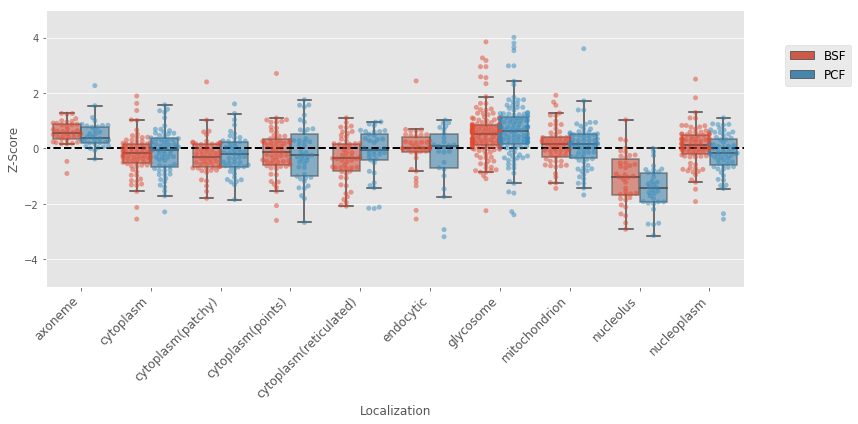

In [43]:

bsf = temp[['locs','BSFn']]
bsf.columns = ['locs','value']
bsf['Life Stage']='BSF'
pcf = temp[['locs','PCFn']]
pcf.columns = ['locs','value']
pcf['Life Stage']='PCF'
swarm_df = pd.concat([bsf,pcf])
fig,ax=plt.subplots(figsize=(12,6))

loc_selection = swarm_df[swarm_df.locs.isin(temp.locs.value_counts().sort_values().tail(10).index)]
loc_selection.to_csv('localization.csv')
print(loc_selection.head())
loc_selection=loc_selection.sort_values('locs')
sns.swarmplot(x="locs", y="value", hue="Life Stage",
                    data=loc_selection,
              dodge=True,ax=ax,alpha=0.5,label=str())



sns.boxplot(x="locs", y="value", hue="Life Stage",
                    data=loc_selection,
              dodge=True,ax=ax,boxprops=dict(alpha=0.6),showfliers=False)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right", fontsize=12)
#ax.legend(handles[0:2], labels[0:2])

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[0:2], labels[0:2], loc='center left', bbox_to_anchor=(1.05, 0.8), fontsize=12)
ax.hlines(y=0,xmin=-1,xmax=10,linestyles='dashed',linewidth=2)
plt.ylim(-5,5)
plt.tight_layout()
ax.set_xlabel('Localization')
ax.set_ylabel('Z-Score')
plt.savefig(os.path.join('Figure','Figure_12.png'))
plt.savefig(os.path.join('Figure','Figure_12.svg'))
plt.show()

# Figure 10
Protein Half-Life and GO Term Enrichment Analysis.

[Back to content](#Table-of-Content) 

In [44]:
def make_assoc(indata=os.path.join('indata','genome','TriTrypDB-41_TbruceiTREU927_GO.gaf'),
               outdata=os.path.join('indata','go','assoc_41.txt')):
    outdata = open(outdata,'w')
    for l in open(indata):
        if l.startswith('!'):
            continue
        item_list = l.split('\t')
        gene_id = item_list[1].strip()
        go_term = item_list[4].strip()
        outdata.write(gene_id+'\t'+go_term+'\n')
    outdata.close()

make_assoc()    

In [45]:
from goatools.base import download_go_basic_obo
from goatools.associations import read_associations
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.obo_parser import GODag

in_go=os.path.join('indata','go', 'go-basic_release_20190127.obo')
in_assoc=os.path.join('indata','go','assoc_41.txt')
gene_found = list(set(list(exp_bsf.index.values)+list(exp_pcf.index.values)))
obodag = GODag(in_go)
geneid2gos = read_associations(in_assoc)
goeaobj = GOEnrichmentStudy(
            gene_found, # List of mouse protein-coding genes
            geneid2gos, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05,#) # default significance cut-off)
            methods = ['bonferroni'])

indata/go/go-basic_release_20190127.obo: fmt(1.2) rel(2019-01-27) 47,381 GO Terms
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 86%  4,038 of  4,686 population items found in association


In [46]:
m_offset = exp_bsf['offset'].median()
print('BSF median offset:', m_offset)
m_tau = exp_bsf['tau'].median()
print('BSF median tau:', m_tau)
temp = exp_bsf[ (exp_bsf['offset']<exp_bsf['offset'].median()) & (exp_bsf['tau']<exp_bsf['tau'].median())]
select=temp[['offset','tau']].sort_values('tau').head(100)
select.to_csv('bsf_tau.csv')
print(select.index.values)
goea_results = goeaobj.run_study(select.index.values)
goea_results = [t for t in goea_results if (t.p_uncorrected<0.05) and (t.study_count>=10)]
print (goea_results)
for t in goea_results:
    print (t.GO, t.NS,t.name, t.p_bonferroni,t.study_count,t.p_uncorrected)
    #print(t.p_bonferroni)

BSF median offset: 1.3844394519679781e-09
BSF median tau: 7.983068828772312
['Tb927.10.890' 'Tb927.6.4820' 'Tb927.10.880' 'Tb927.9.3390' 'Tb927.8.910'
 'Tb927.6.440' 'Tb927.9.9520' 'Tb927.9.7980' 'Tb927.1.5170'
 'Tb927.11.11135' 'Tb927.7.6900' 'Tb927.4.5220' 'Tb927.9.4200'
 'Tb927.7.3260' 'Tb927.11.1300' 'Tb927.7.6960' 'Tb927.9.14290'
 'Tb927.8.4190' 'Tb927.10.4990' 'Tb927.10.12540' 'Tb927.1.4910'
 'Tb927.3.1910' 'Tb927.11.13270' 'Tb927.11.6430' 'Tb927.11.3760'
 'Tb927.10.11960' 'Tb927.11.16390' 'Tb927.8.2780' 'Tb927.11.13610'
 'Tb927.2.3580' 'Tb927.11.15980' 'Tb927.10.15680' 'Tb927.11.17870'
 'Tb927.4.4580' 'Tb927.11.2890' 'Tb927.6.650' 'Tb927.11.8870'
 'Tb11.v5.0228' 'Tb927.9.8180' 'Tb927.11.6600' 'Tb927.4.4570'
 'Tb11.v5.0826' 'Tb927.8.5220' 'Tb927.5.2660' 'Tb927.5.1100'
 'Tb927.7.6790' 'Tb927.11.2970' 'Tb927.1.1630' 'Tb927.10.14810'
 'Tb927.10.1450' 'Tb927.5.1620' 'Tb927.3.1085' 'Tb927.10.5250'
 'Tb927.5.2090' 'Tb927.9.6760' 'Tb927.7.3700' 'Tb927.8.1750'
 'Tb927.6.4600' 'Tb927.10.1

In [47]:
m_offset = exp_pcf['offset'].median()
print('PCF median offset:', m_offset)
m_tau = exp_pcf['tau'].median()
print('PCF median tau:', m_tau)
temp = exp_pcf[ (exp_pcf['offset']<exp_pcf['offset'].median()) & (exp_pcf['tau']<exp_pcf['tau'].median())]
select=temp[['offset','tau']].sort_values('tau').head(100)
goea_results = goeaobj.run_study(select.index.values)
goea_results = [t for t in goea_results if (t.p_uncorrected<0.05) and (t.study_count>=10)]
print (goea_results)
for t in goea_results:
     print (t.GO, t.NS,t.name, t.p_bonferroni,t.study_count,t.p_uncorrected)

PCF median offset: 0.0834164885604457
PCF median tau: 16.709554071775365
 88%     88 of    100 study items found in association
100%    100 of    100 study items found in population(4686)
Calculating 1,739 uncorrected p-values using fisher_scipy_stats
   1,739 GO terms are associated with  4,037 of  4,686 population items
     152 GO terms are associated with     88 of    100 study items
       0 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
[GOEnrichmentRecord(GO:0010608), GOEnrichmentRecord(GO:0003723)]
GO:0010608 BP posttranscriptional regulation of gene expression 0.14573742096479264 16 8.38053024524397e-05
GO:0003723 MF RNA binding 1.0 10 0.004693515561616215


 84%    354 of    419 study items found in association
100%    419 of    419 study items found in population(4686)
Calculating 1,739 uncorrected p-values using fisher_scipy_stats
   1,739 GO terms are associated with  4,037 of  4,686 population items
     292 GO terms are associated with    354 of    419 study items
       1 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
 86%    359 of    418 study items found in association
100%    418 of    418 study items found in population(4686)
Calculating 1,739 uncorrected p-values using fisher_scipy_stats
   1,739 GO terms are associated with  4,037 of  4,686 population items
     374 GO terms are associated with    359 of    418 study items
       1 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
 87%    362 of    418 study items found in association
100%    418 of    418 study items found in population(4686)
Calculating 1,739 uncorrected p-values using fisher_scipy

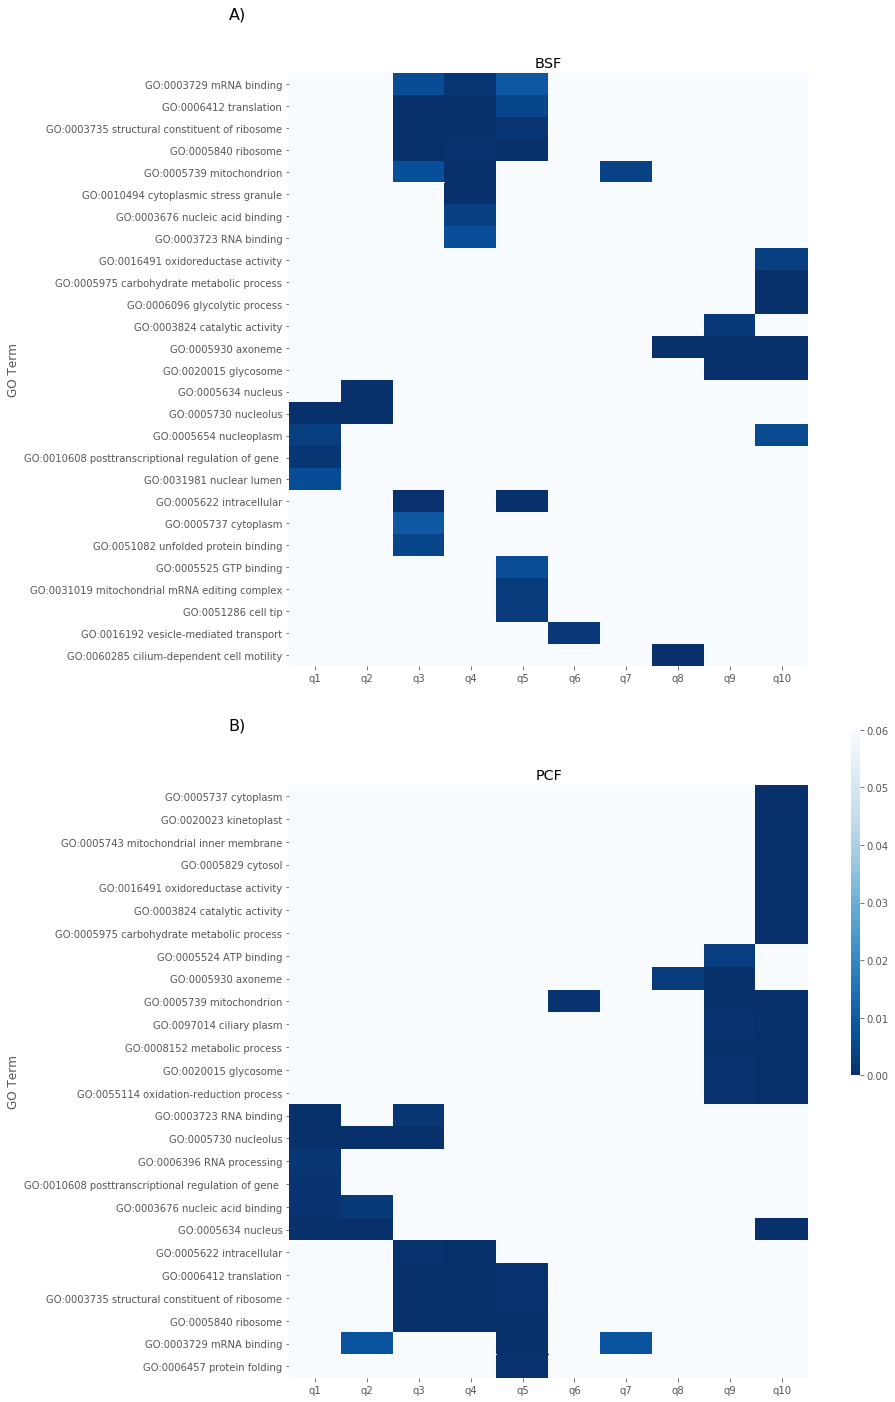

In [48]:
import scipy.cluster.hierarchy as sch
def get_go_table(indata, field, nq=5):
    indata['quantile'] = pd.qcut(indata[field], nq, labels=np.arange(1, nq+1, 1))
    #print(indata.sort_values('quantile').head())
    #print(indata['quantile'].value_counts())
    all_res = pd.DataFrame()
    for item in range(1, nq+1):
        prots = indata[indata['quantile']==item].index.values
        #open('go_tables/dec_'+str(item)+'.txt','w').write('\n'.join(prots))
        goea_results = goeaobj.run_study(prots)
        goea_results = [t for t in goea_results if (t.p_uncorrected<0.01) and (t.study_count>10)]#.p_uncorrected
        if len(goea_results)>0:
            goea_dict = {}
            #print ('goea_results',len(goea_results))
            for index, t in enumerate(goea_results):
                goea_dict[t.GO+' '+t.name] = [t.p_uncorrected]
            goea_df=pd.DataFrame.from_dict(goea_dict,orient='index')
            goea_df.columns = ['q'+str(item)]
            all_res=all_res.join(goea_df,how='outer')
    return all_res


def round_go_name(indf, nchars=80):
    indf['GO Term']=indf.index.values
    indf['GO Term']=[n[0:nchars] for n in indf['GO Term'].values]
    indf=indf.set_index(indf['GO Term'])
    indf.drop('GO Term',axis=1,inplace=True)
    return indf


bsf_values = exp_bsf[['offset', 'tau', 'amplitude', 'new_half_life']]
bsf_go = get_go_table(bsf_values, 'new_half_life', nq=10)
bsf_go = bsf_go[bsf_go.isna().sum(axis=1)>=5]
bsf_go = round_go_name(bsf_go, nchars=50)

pcf_values = exp_pcf[['offset', 'tau', 'amplitude', 'new_half_life']]
pcf_go = get_go_table(pcf_values, 'new_half_life', nq=10)
pcf_go = pcf_go[pcf_go.isna().sum(axis=1)>=5]
pcf_go = round_go_name(pcf_go, nchars=50)

def make_go_plot(indata, fillna = 0.05 ,ax=''):
    #all_res = all_res[all_res.notna().count(axis=1)<=1]
    indata = indata.fillna(fillna)
    #all_res[all_res.sum(axis=1)>40]
    #print (indata.head())
    link = sch.linkage(indata, 'ward', 'euclidean')
    den_rows = sch.dendrogram(link, no_plot=True)
    cbar_ax = fig.add_axes([.95, .3, .01, .2])
    #sns.heatmap(arr, ax=ax, cbar_ax = cbar_ax, cbar=True)
    sns.heatmap(indata.iloc[den_rows['leaves']], annot=False, cmap='Blues_r',ax=ax, cbar_ax = cbar_ax, cbar=True)
    
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(12, 24))
make_go_plot(bsf_go, fillna = 0.06, ax=axes[0])
axes[0].set_title('BSF')


ax = make_go_plot(pcf_go, fillna = 0.06, ax=axes[1])
axes[1].set_title('PCF')
fig.subplots_adjust(wspace=2.8)


axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[0].transAxes,fontsize=16)

'''
axes[0].annotate('', xy=(0, -2),xytext=(3,-2.09),                     #draws an arrow from one set of coordinates to the other
            arrowprops=dict(arrowstyle='<->',facecolor='red'),   #sets style of arrow and colour
            annotation_clip=False)                               #This enables the arrow to be outside of the plot
axes[0].annotate('xyz',xy=(1.1,1.1),xytext=(1.1,1.1),               #Adds another annotation for the text that you want
            annotation_clip=False)
'''



axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)

plt.gcf().subplots_adjust(left=0.3)
plt.savefig(os.path.join('Figure','Figure_10.png'))
plt.savefig(os.path.join('Figure','Figure_10.svg'))
plt.show()



In [49]:
bsf_bins = pd.qcut(exp_bsf['new_half_life'], 10, labels=np.arange(1, 11, 1))
pcf_bins = pd.qcut(exp_pcf['new_half_life'], 10, labels=np.arange(1, 11, 1))
pcf_bins=pcf_bins.to_dict()
bsf_bins=bsf_bins.to_dict()
TablePCF['bins']=[pcf_bins[n] if n in pcf_bins else 'none' for n in TablePCF.index.values]
TableBSF['bins']=[bsf_bins[n] if n in bsf_bins else 'none' for n in TableBSF.index.values]

# Figure 11
Linear Motif

[Back to content](#Table-of-Content) 

In [50]:
import re
from Bio import SeqIO

def count_comment_line(infile='', tag='##'):
    a=0
    for l in open(infile):
        if l.startswith(tag):
            a+=1
        else:
            break
    return a

def find_motif(prot,motif):
    return len(motif.findall(prot))

infile=os.path.join('indata', 'elm_classes.tsv')
count=count_comment_line(infile=infile, tag='#')
elm = pd.read_table(infile,skiprows=count)
elm.head()
elm_dict = {}
for r,s in zip(elm.ELMIdentifier, elm.Regex):
    elm_dict[r]=re.compile(s)

motif_dict={}
infile=os.path.join('indata','genome','TriTrypDB-41_TbruceiTREU927_AnnotatedProteins.fasta')
handle = open(infile, "rU")    
for record in tqdm_notebook(SeqIO.parse(handle, "fasta")):
    temp_id = clean_id (record.id)
    seq = str(record.seq)
    res = [find_motif(seq, motif) for motif in elm_dict.values()]
    #print (res)
    motif_dict[temp_id]=res

motif_dict = pd.DataFrame.from_dict(motif_dict,orient='index')           
motif_dict.head()
motif_dict.columns = elm_dict.keys()

motif_dict['ELM_CLV'] = motif_dict[[n for n in motif_dict.columns if n.startswith('CLV')]].sum(axis=1)
motif_dict['ELM_DEG'] = motif_dict[[n for n in motif_dict.columns if n.startswith('DEG')]].sum(axis=1)
motif_dict['ELM_DOC'] = motif_dict[[n for n in motif_dict.columns if n.startswith('DOC')]].sum(axis=1)
motif_dict['ELM_LIG'] = motif_dict[[n for n in motif_dict.columns if n.startswith('LIG')]].sum(axis=1)
motif_dict['ELM_MOD'] = motif_dict[[n for n in motif_dict.columns if n.startswith('MOD')]].sum(axis=1)
motif_dict['ELM_TRG'] = motif_dict[[n for n in motif_dict.columns if n.startswith('TRG')]].sum(axis=1)
motif_dict.head()

,CLV_C14_Caspase3-7,CLV_MEL_PAP_1,CLV_NRD_NRD_1,CLV_PCSK_FUR_1,CLV_PCSK_KEX2_1,CLV_PCSK_PC1ET2_1,CLV_PCSK_PC7_1,CLV_PCSK_SKI1_1,CLV_Separin_Fungi,CLV_Separin_Metazoa,...,TRG_NLS_MonoExtC_3,TRG_NLS_MonoExtN_4,TRG_PTS1,TRG_PTS2,ELM_CLV,ELM_DEG,ELM_DOC,ELM_LIG,ELM_MOD,ELM_TRG
Tb927.1.05,4,0,3,0,2,1,0,5,0,0,...,0,1,0,0,15,1,14,37,58,2
Tb927.1.1000,2,0,1,0,3,2,0,11,0,0,...,0,0,0,0,19,2,15,53,42,9
Tb927.1.100,0,0,6,1,3,0,1,7,0,2,...,1,0,0,0,20,3,20,69,57,15
Tb927.1.1010,3,0,4,1,4,2,1,13,0,0,...,0,0,0,0,28,3,39,93,88,9
Tb927.1.1020,2,0,1,0,1,0,0,4,0,1,...,0,0,0,0,9,1,11,56,54,8


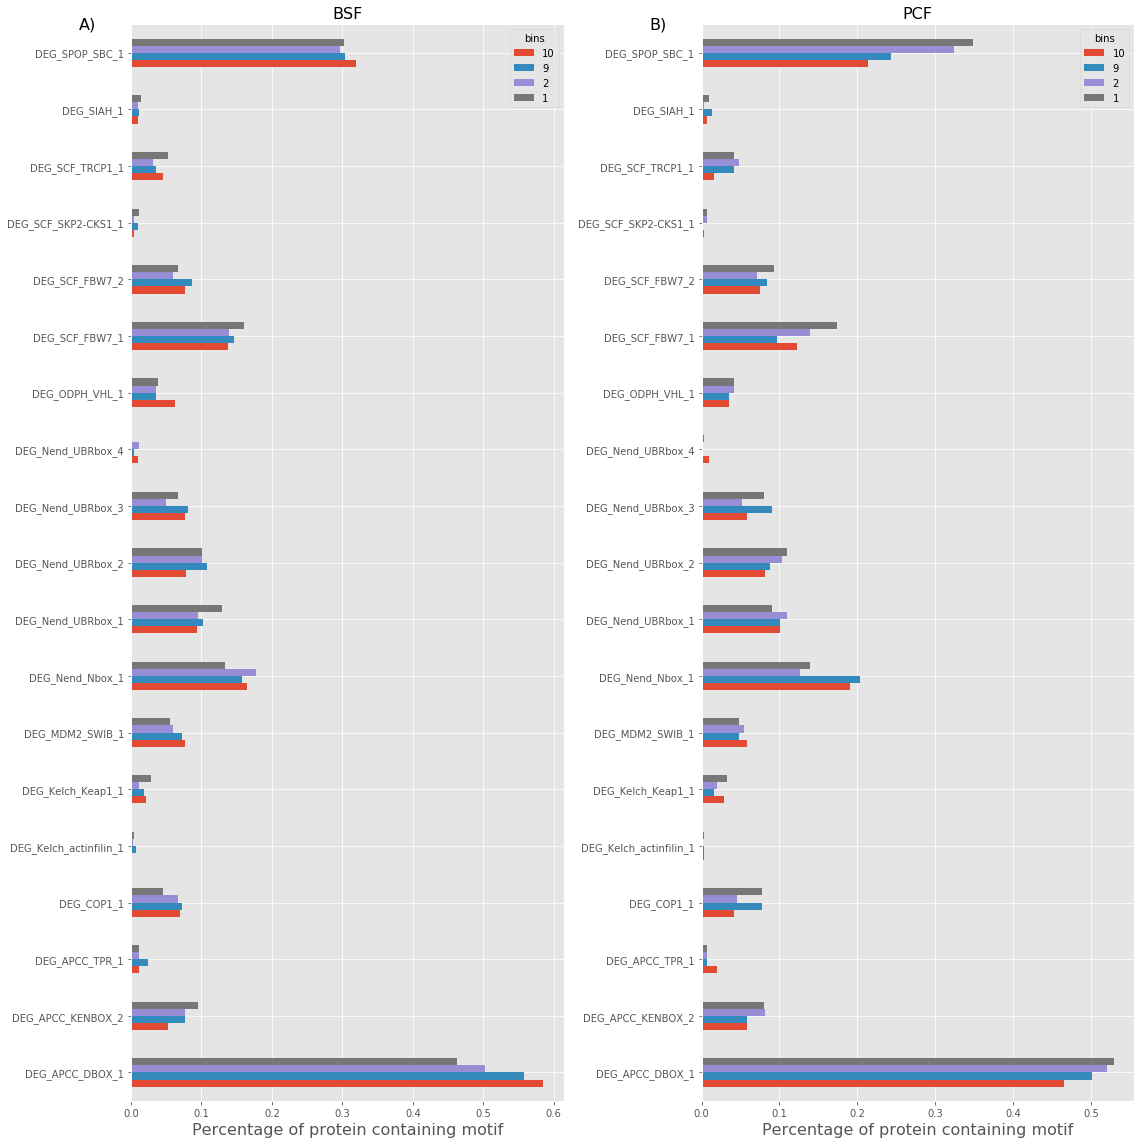

In [51]:
fig,axes=plt.subplots(figsize=(16,16),ncols=2)


analysis = motif_dict[[n for n in motif_dict.columns if n.startswith('DEG')]]
analysis[analysis>1]=1
analysis['bins']=[str(bsf_bins[n]) if n in bsf_bins else np.nan for n in analysis.index.values ]
analysis=analysis[~analysis['bins'].isna()]
analysis = analysis[analysis['bins']!='nan']
analysis = analysis.groupby('bins').sum().divide(analysis.groupby('bins').size(),axis=0)
analysis = analysis.T
analysis = analysis[analysis.sum(axis=1)>0]
analysis[['10','9','2','1']].plot(kind='barh',ax=axes[0])


analysis = motif_dict[[n for n in motif_dict.columns if n.startswith('DEG')]]
analysis[analysis>1]=1
analysis['bins']=[str(pcf_bins[n]) if n in pcf_bins else np.nan for n in analysis.index.values ]
analysis=analysis[~analysis['bins'].isna()]
analysis = analysis[analysis['bins']!='nan']
analysis = analysis.groupby('bins').sum().divide(analysis.groupby('bins').size(),axis=0)
analysis = analysis.T
analysis = analysis[analysis.sum(axis=1)>0]
analysis[['10','9','2','1']].plot(kind='barh',ax=axes[1])

axes[0].set_title('BSF',fontsize=16)
axes[1].set_title('PCF',fontsize=16)

axes[1].set_xlabel('Percentage of protein containing motif',fontsize=16)
axes[0].set_xlabel('Percentage of protein containing motif',fontsize=16)


axes[0].text(-0.1, 1, 'A)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[0].transAxes,fontsize=16)

axes[1].text(-0.1, 1, 'B)', horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[1].transAxes,fontsize=16)

plt.tight_layout()

plt.savefig(os.path.join('Figure','Figure_11.png'))
plt.savefig(os.path.join('Figure','Figure_11.svg'))
plt.show()


# Figure 14
Protein Half-Life and Cell Cycle Regulated Proteins

[Back to content](#Table-of-Content) 

Tb927.9.8380    1.331772
Tb927.9.8500    1.346265
Tb927.9.9520    1.555816
Tb927.9.9810    1.419687
Tb927.9.9950    1.328109
Name: fold_change, dtype: float64
Tb11.1810b;Tb11.1810;Tb11.v5.0839    1.330764
Tb11.v5.0394                         1.360534
Tb11.v5.0515;Tb927.10.15300          1.428538
Tb11.v5.0553                         1.383520
Tb11.v5.0627;Tb927.10.13680          1.317195
Name: fold_change, dtype: float64
6.30081543656004
5.67270461101952


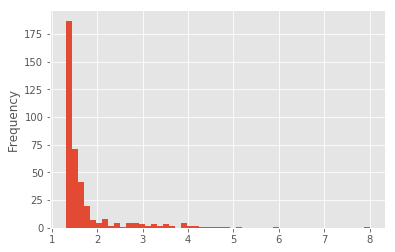

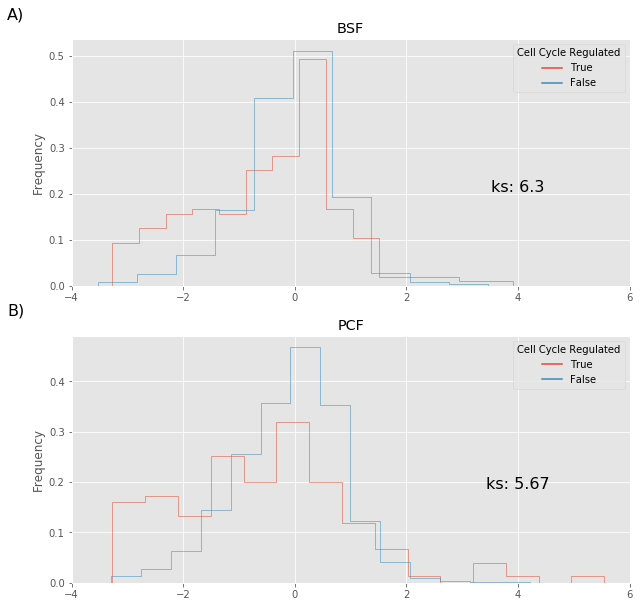

In [52]:
cell_cycle = pd.read_csv('indata/cell_cycle/final_dataset_clustered_annotated.csv',index_col=[0])
cell_cycle = cell_cycle[cell_cycle['cell_cycle_regulated']==1]
cell_cycle.head()
cell_cycle['protein_id']=[item.split(';')[0] for item in cell_cycle.index.values]
cell_cycle.shape
cell_cycle['fold_change'].plot(kind='hist',bins=50)
cell_cycle = cell_cycle[cell_cycle['fold_change']>1.3]#.sort_values('fold_change').tail(100)
print(cell_cycle['fold_change'].tail())
print(cell_cycle['fold_change'].head())



temp = pd.DataFrame()

bsf_data = (exp_bsf['new_half_life']-exp_bsf['new_half_life'].median())/exp_bsf['new_half_life'].std(ddof=0)
pcf_data = (exp_pcf['new_half_life']-exp_pcf['new_half_life'].median())/exp_pcf['new_half_life'].std(ddof=0)
temp['hlife'] = list(bsf_data)+list(pcf_data)
temp['stage']=['BSF' for n in exp_bsf.index.values]+['PCF' for n in exp_pcf.index.values]
temp['index']=list(exp_bsf['new_half_life'].index) + list(exp_pcf['new_half_life'].index)
temp['Cell Cycle Regulated']=[True if n in set(cell_cycle['protein_id']) else False for n in temp['index']]
temp.to_csv('cell_cycle.csv')

len(cell_cycle['protein_id'])
temp.head()


from matplotlib.lines import Line2D
fig,axes=plt.subplots(ncols=1,nrows=2,figsize=(10,10))
temp[(temp['stage']=='BSF')&temp['Cell Cycle Regulated']].plot(kind='hist',
                                                               histtype='step',
                                                               ax=axes[0],
                                                               normed=True,
                                                               bins=15,
                                                              )
temp[(temp['stage']=='BSF')&~temp['Cell Cycle Regulated']].plot(kind='hist',
                                                                histtype='step',
                                                                ax=axes[0],
                                                                normed=True,
                                                               bins=35,
                                                                label='False')


temp[(temp['stage']=='PCF')&temp['Cell Cycle Regulated']].plot(kind='hist',
                                                               histtype='step',
                                                               ax=axes[1],
                                                               normed=True,
                                                               bins=15)
temp[(temp['stage']=='PCF')&~temp['Cell Cycle Regulated']].plot(kind='hist',
                                                                histtype='step',
                                                                ax=axes[1],
                                                                normed=True,
                                                                bins=20,
                                                               )

handles, labels = axes[0].get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
labels = ['True', 'False']
axes[0].legend(handles=new_handles, labels=labels, title = 'Cell Cycle Regulated')

handles, labels = axes[1].get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
labels = ['True', 'False']
axes[1].legend(handles=new_handles, labels=labels,title = 'Cell Cycle Regulated')

axes[0].set_title('BSF')
axes[1].set_title('PCF')
axes[0].set_xlim(-4,6)
axes[1].set_xlim(-4,6)

axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[0].transAxes,fontsize=16)

axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)


from scipy.stats import ks_2samp
stat_1= ks_2samp(temp[(temp['stage']=='BSF')&(temp['Cell Cycle Regulated']==0)]['hlife'], temp[(temp['stage']=='BSF')&(temp['Cell Cycle Regulated']==1)]['hlife'])
print(-np.log10(stat_1.pvalue))
stat_2= ks_2samp(temp[(temp['stage']=='PCF')&(temp['Cell Cycle Regulated']==0)]['hlife'], temp[(temp['stage']=='PCF')&(temp['Cell Cycle Regulated']==1)]['hlife'])
print(-np.log10(stat_2.pvalue))


stat_1 = round(-np.log10(stat_1[1]),2)    
axes[0].text(0.8, 0.4, 'ks: '+str(stat_1), horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[0].transAxes,fontsize=16)

stat_2 = round(-np.log10(stat_2[1]),2)    
axes[1].text(0.8, 0.4, 'ks: '+str(stat_2), horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)


plt.savefig(os.path.join('Figure','Figure_14.png'))
plt.savefig(os.path.join('Figure','Figure_14.svg'))

In [53]:
bsf = pd.read_table('indata/combined_noreq_bs/txt/proteinGroups.txt')
bsf=clean(bsf)
bsf['protein_id']=[clean_id(n) for n in bsf['Protein IDs']]
bsf.drop_duplicates('protein_id',inplace=True)
bsf.set_index('protein_id', inplace=True)
intensity_columns = [n for n in bsf.columns if n.startswith('Intensity H ') ]
bsf['abundance'] = np.log10(bsf[intensity_columns].mean(axis=1,skipna=True)+1)

pcf = pd.read_table('indata/combined_noreq_pc/txt/proteinGroups.txt')
pcf=clean(pcf)
pcf['protein_id']=[clean_id(n) for n in pcf['Protein IDs']]
pcf.drop_duplicates('protein_id',inplace=True)
pcf.set_index('protein_id', inplace=True)
intensity_columns = [n for n in pcf.columns if n.startswith('Intensity H ') ]
pcf['abundance'] = np.log10(pcf[intensity_columns].mean(axis=1,skipna=True)+1)
pcf['abundance'].head()


(6456, 630)
removed  84 Only identified by site
tot  84  entries removed
---------------
removed  63 Reverse
tot  147  entries removed
---------------
removed  134 Potential contaminant
tot  281  entries removed
---------------
removed  152 Peptide counts (all)
tot  433  entries removed
---------------
(6466, 790)
removed  189 Only identified by site
tot  189  entries removed
---------------
removed  62 Reverse
tot  251  entries removed
---------------
removed  114 Potential contaminant
tot  365  entries removed
---------------
removed  206 Peptide counts (all)
tot  571  entries removed
---------------


protein_id
Tb927.5.4450    7.455144
Tb927.5.4460    8.416004
Tb927.5.4470    7.613866
Tb927.5.4480    8.769042
Tb927.5.4500    8.260520
Name: abundance, dtype: float64

In [54]:
#list(bsf.columns)

In [55]:
exp_bsf['new_half_life'].shape, exp_pcf['new_half_life'].shape, bsf['abundance'].shape

((4194,), (3092,), (6021,))

In [56]:
bsf['prot']=bsf.index.values
bsf['prot'].value_counts().head()
#bsf.drop(['Tb927.10.9190','Tb927.7.6460'],inplace=True,axis=0)

Tb927.8.2620      1
Tb927.6.2390      1
Tb927.11.15210    1
Tb927.11.16860    1
Tb927.10.1800     1
Name: prot, dtype: int64

In [57]:
pcf['prot']=pcf.index.values
pcf['prot'].value_counts().head()

Tb927.10.9590     1
Tb927.6.4570      1
Tb927.10.1800     1
Tb927.10.12200    1
Tb927.6.1980      1
Name: prot, dtype: int64

# Figure 13
Protein Half-Life and Protein Abundance Analysis

[Back to content](#Table-of-Content)

In [58]:
temp=pd.concat([exp_bsf['new_half_life'], 
                exp_pcf['new_half_life'], 
                bsf['abundance'], 
                pcf['abundance'],
               ], axis=1)
temp.columns= ['half_life_bsf','half_life_pcf', 'abundance_bsf',
               'abundance_pcf']
#temp.plot(kind='scatter',x='half_life_bsf',y='abundance_bsf')
#temp.plot(kind='scatter',x='half_life_pcf',y='abundance_pcf')
temp['quantile_bsf'] = pd.qcut(temp['half_life_bsf'], 10, labels=np.arange(1, 10+1, 1))
temp['quantile_pcf'] = pd.qcut(temp['half_life_pcf'], 10, labels=np.arange(1, 10+1, 1))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


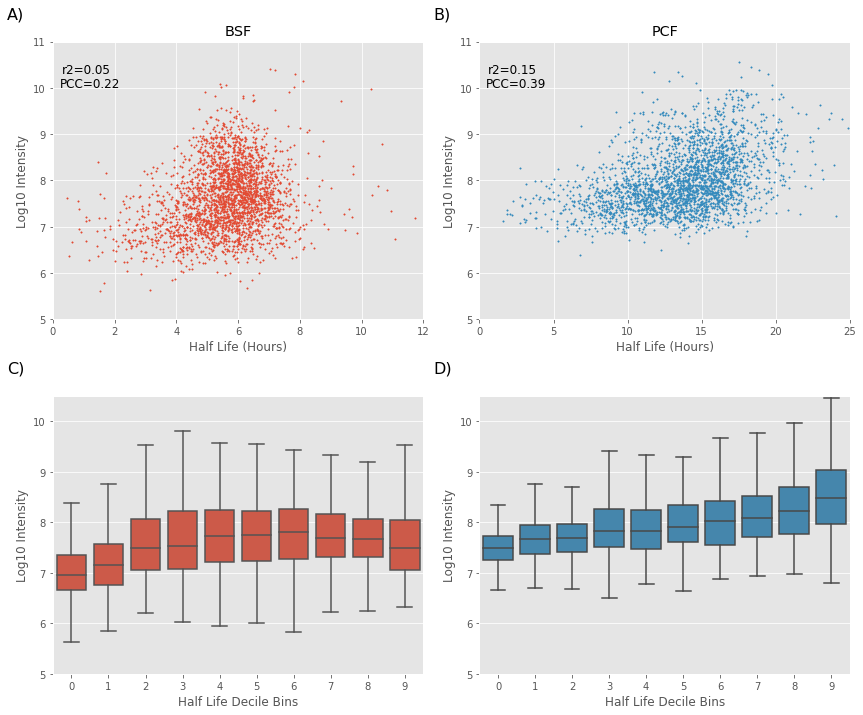

In [59]:
fig,axes = plt.subplots(figsize=(12, 10),ncols=2,nrows=2)
temp = temp[ ~temp['half_life_bsf'].isnull() &  ~temp['half_life_pcf'].isnull()]
temp.plot(kind='scatter', x="half_life_bsf",y='abundance_bsf',
          ax=axes[0,0],c=current_palette[0],s=2)
temp.plot(kind='scatter', x="half_life_pcf",y='abundance_pcf',
          ax=axes[0,1],c=current_palette[1],s=2)
axes[0,0].set_xlim(0,12)
axes[0,1].set_xlim(0,25)

axes[0,0].set_ylim(5,11)
axes[0,1].set_ylim(5,11)


axes[0,0].text(0.09, 0.9, 'r2='+str(r2(temp['half_life_bsf'], temp['abundance_bsf'])), horizontalalignment='center', 
               verticalalignment='center', fontsize=12,
               transform=axes[0,0].transAxes)
axes[0,0].text(0.1, 0.85, 'PCC='+str(pcc(temp['half_life_bsf'], temp['abundance_bsf'])), horizontalalignment='center', 
               verticalalignment='center', fontsize=12,
               transform=axes[0,0].transAxes)


axes[0,1].text(0.09, 0.9, 'r2='+str(r2(temp['half_life_pcf'], temp['abundance_pcf'])), horizontalalignment='center', 
               verticalalignment='center', fontsize=12,
               transform=axes[0,1].transAxes)
axes[0,1].text(0.1, 0.85, 'PCC='+str(pcc(temp['half_life_pcf'], temp['abundance_pcf'])), horizontalalignment='center', 
               verticalalignment='center', fontsize=12,
               transform=axes[0,1].transAxes)



axes[0,0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[0,0].transAxes,fontsize=16)

axes[0,1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[0,1].transAxes,fontsize=16)

axes[0,0].set_title('BSF')
axes[0,1].set_title('PCF')

axes[0,0].set_ylabel('Log10 Intensity')
axes[0,1].set_ylabel('Log10 Intensity')
axes[0,0].set_xlabel('Half Life (Hours)')
axes[0,1].set_xlabel('Half Life (Hours)')


res = []
for n in temp.groupby('quantile_bsf')['abundance_bsf']:
    res.append(n[1])
sns.boxplot(data=res,ax=axes[1,0],
            color=current_palette[0],
           showfliers=False)#.boxplot(res)  



res = []
for n in temp.groupby('quantile_pcf')['abundance_pcf']:
    res.append(n[1])
sns.boxplot(data=res,ax=axes[1,1],
            color=current_palette[1],
           showfliers=False)#.boxplot(res)  

axes[1,0].set_ylabel('Log10 Intensity')
axes[1,1].set_ylabel('Log10 Intensity')
axes[1,0].set_xlabel('Half Life Decile Bins')
axes[1,1].set_xlabel('Half Life Decile Bins')


axes[1,0].text(-0.1, 1.1, 'C)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1,0].transAxes,fontsize=16)

axes[1,1].text(-0.1, 1.1, 'D)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1,1].transAxes,fontsize=16)




axes[1,0].set_ylim(5,10.5)
axes[1,1].set_ylim(5,10.5)
plt.tight_layout()
plt.savefig(os.path.join('Figure','Figure_13.png'))
plt.savefig(os.path.join('Figure','Figure_13.svg'))
plt.show()

# Figure 15
Protein Half-Life and Protein Complex Analysis

[Back to content](#Table-of-Content) 

In [60]:
from scipy.stats import ks_2samp
import random
from tqdm import tqdm_notebook as tqdm

def plot_cumstd(complexes='', df='', ax='', cycles = '', field='offset'):
    std = []
    for n in complexes:
        std.append(np.log(df.loc[n][field].var()))
    
    values, base = np.histogram(std, bins=20)  
    cumulative = np.cumsum(values)
    temp=pd.DataFrame()
    temp['log_std']=base[:-1]
    temp['cumulative']=cumulative
    temp['cumulative']=temp['cumulative']/temp['cumulative'].max()
    sns.lineplot(x="log_std", y="cumulative",
             data=temp,ax=ax, color='b', label='cum var '+field)

    all_r_std = []

    for item in tqdm(range(0,cycles)):
        np.random.seed(item)
        r_std = []
        for n in complex_list: 
            n = random.sample(list(df.index.values), len(n))
            r_std.append(np.log(df.loc[n][field].var()))    
        r_values, r_base = np.histogram(r_std, bins=20)  
        r_cumulative = np.cumsum(r_values)
        
        temp=pd.DataFrame()
        temp['log_std']=r_base[:-1]
        temp['cumulative']=r_cumulative
        temp['cumulative']=temp['cumulative']/temp['cumulative'].max()
        sns.lineplot(x="log_std", y="cumulative",
             data=temp,ax=ax,color='r', alpha=0.01)        
        all_r_std+=r_std

    sns.lineplot(x="log_std", y="cumulative", data=temp,ax=ax,
                 color='r', alpha=0.1, label='cum random var '+field)
    
    stat_1= ks_2samp(std, all_r_std)
    stat_1 = round(-np.log10(stat_1[1]),2)
    ax.text(0.2, 0.8, 'ks: '+str(stat_1), horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)  
    
    ax.text(0.2, 0.5, 'n: '+str(len(std)), horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)  



def plot_cumdiff(pairs='', df='', ax='', cycles = '', field='offset'):
    diff_list = []
    for n in complex_list:
        diff_list.append(abs(df.loc[n[0]][field]-df.loc[n[1]][field]))
    
    values, base = np.histogram(diff_list, bins=20)
    cumulative = np.cumsum(values)
    temp=pd.DataFrame()
    temp['log_dif']=base[:-1]
    temp['cumulative']=cumulative
    temp['cumulative']=temp['cumulative']/temp['cumulative'].max()
    #plt.plot(base[:-1], cumulative, c='blue')
    sns.lineplot(x="log_dif", y="cumulative",
             #hue="stage",ci='sd',
             data=temp, ax=ax, color='b',label='diff '+field)
    
    diff_list_random=[]
    for item in tqdm(range(0,cycles)):
        np.random.seed(item)
        temp_difference = []
        for n in pairs: 
            n = random.sample(list(df.index.values), 2)
            temp_difference.append(  abs(df.loc[n[0]][field]-df.loc[n[1]][field]) )   
        r_values, r_base = np.histogram(temp_difference, bins=20) 
        r_cumulative = np.cumsum(r_values)
        temp=pd.DataFrame()
        temp['log_dif']=r_base[:-1]
        temp['cumulative']=r_cumulative
        temp['cumulative']=temp['cumulative']/temp['cumulative'].max()
        sns.lineplot(x="log_dif", y="cumulative",
             data=temp,ax=ax,color='r',alpha=0.01)
    
    diff_list_random+=temp_difference
    sns.lineplot(x="log_dif", y="cumulative",
             data=temp,ax=ax,color='r',alpha=0.01,label='random diff '+field )

    stat_1= ks_2samp(diff_list, diff_list_random)
    stat_1 = round(-np.log10(stat_1[1]),2)    
    ax.text(0.2, 0.8, 'ks: '+str(stat_1), horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)  
    ax.text(0.2, 0.5, 'n: '+str(len(diff_list)), horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)  

    

    


In [61]:
def make_go_annot(gene_ids):
    res = []
    for gene_id in gene_ids:
        temp_res=[]
        go_ids = geneid2gos.get(gene_id)
        if str(go_ids) != 'None':
            names = []
            for go_id in go_ids:
                name = obodag.get(go_id)
                if str(name) != 'None':
                    names.append(name.name)
                else:
                    names.append('none')
                    
            for a,b in zip(go_ids, names):
                temp_res.append(a+'|'+b)
        else:
            temp_res.append('none')
        res.append('; '.join(temp_res))
    return res
        
#make_go_annot(TablePCF.index.values)
TablePCF['GO'] = make_go_annot(TablePCF.index.values)
TableBSF['GO'] = make_go_annot(TableBSF.index.values)
TablePCF.to_csv('Table_S3d.csv')
TableBSF.to_csv('Table_S2d.csv')

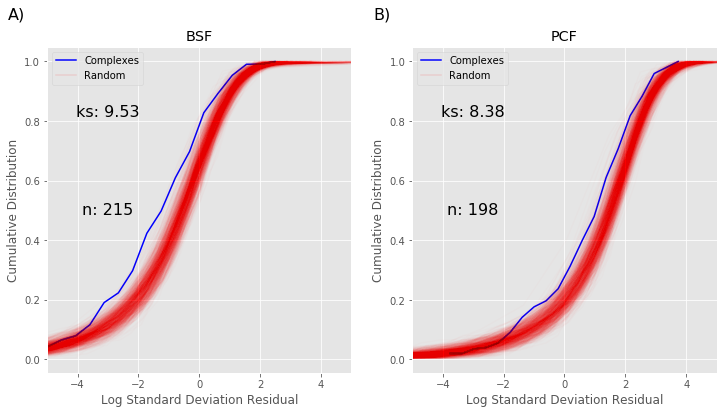

In [62]:
fig,axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6))    

'''
selection = exp_bsf.copy()
complex_list = open('indata/complexes/gd.txt').read().split('\n')
complex_list = [n.split('\t') for n in complex_list]
complex_list = [list(set(n)&set(selection.index.values)) for n in complex_list  ]
complex_list = [n for n in complex_list if len(n) >= 2]

plot_cumdiff(pairs=complex_list, df=selection, ax=axes[0,0], cycles = 100, field='exp_residual_hlife')

complex_list = open('indata/complexes/final_complexes.txt').read().split('\n')
complex_list = [n.split('\t') for n in complex_list]
complex_list = [list(set(n)&set(selection.index.values)) for n in complex_list  ]
complex_list = [n for n in complex_list if len(n) >= 2]
 
plot_cumstd(complexes=complex_list, df=selection, ax=axes[1,0], cycles = 100, field='exp_residual_hlife')
'''

selection = exp_bsf.copy()
selection = selection.dropna(subset=['new_half_life'])
complex_list = open('indata/complexes/final_complexes.txt').read().split('\n')
complex_list = [n.split('\t') for n in complex_list]
complex_list = [list(set(n)&set(selection.index.values)) for n in complex_list  ]
complex_list = [n for n in complex_list if len(n) >= 2]
 
plot_cumstd(complexes=complex_list, df=selection, ax=axes[0], cycles = 1000, field='new_half_life')

selection = exp_pcf.copy()
selection = selection.dropna(subset=['new_half_life'])
complex_list = open('indata/complexes/final_complexes.txt').read().split('\n')
complex_list = [n.split('\t') for n in complex_list]
complex_list = [list(set(n)&set(selection.index.values)) for n in complex_list  ]
complex_list = [n for n in complex_list if len(n) >= 2]

plot_cumstd(complexes=complex_list, df=selection, ax=axes[1], cycles = 1000, field='new_half_life')


axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[0].transAxes,fontsize=16)

axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)

'''
axes[1,0].text(-0.1, 1.1, 'C)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1,0].transAxes,fontsize=16)

axes[1,1].text(-0.1, 1.1, 'D)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1,1].transAxes,fontsize=16)
'''

axes[0].set_title('BSF')
axes[1].set_title('PCF')

L=axes[0].legend()
L.get_texts()[0].set_text('Complexes')
L.get_texts()[1].set_text('Random')

L=axes[1].legend()
L.get_texts()[0].set_text('Complexes')
L.get_texts()[1].set_text('Random')

#axes[0].set_title('predicted complexes')
#axes[1].set_title('predicted complexes')

#axes[0,0].set_ylabel('Cumulative Distribution')
#axes[0,0].set_xlabel('Offset Difference')
#axes[0,1].set_ylabel('Cumulative Distribution')
#axes[0,1].set_xlabel('Offset Difference')

axes[0].set_ylabel('Cumulative Distribution')
axes[0].set_xlabel('Log Standard Deviation Residual')
axes[1].set_ylabel('Cumulative Distribution')
axes[1].set_xlabel('Log Standard Deviation Residual')

axes[0].set_xlim(-5,5)
axes[1].set_xlim(-5,5)

#axes[0,0].legend()
fig.subplots_adjust(hspace=0.3)
plt.savefig(os.path.join('Figure','Figure_15.png'))
plt.savefig(os.path.join('Figure','Figure_15.png'))
plt.show()
    

In [63]:
cols = '''amplitude	amplitude_err	tau	tau_err	offset	offset_err	new_half_life	bins	exp_rmse	protein_groups	desc	used_for_analysis	GO	0h_A	05h_A	1h_A	2h_A	4h_A	8h_A	12h_A	0h_B	05h_B	1h_B	2h_B	4h_B	8h_B	12h_B	0h_C	05h_C	1h_C	2h_C	4h_C	8h_C	12h_C'''.split('\t')
print (cols)
TableBSF=TableBSF[cols]
TableBSF.to_csv('Table_S2.csv')
cols = '''amplitude	amplitude_err	tau	tau_err	offset	offset_err	new_half_life	bins	exp_rmse	protein_groups	desc	used_for_analysis	GO	0h_A	025h_A	0.5h_A	1h_A	2h_A	4h_A	8h_A	20h_A	28h_A	0h_B	025h_B	0.5h_B	1h_B	2h_B	4h_B	8h_B	20h_B	28h_B	0h_C	025h_C	0.5h_C	1h_C	2h_C	4h_C	8h_C	20h_C	28h_C'''.split('\t')
print (cols)
TablePCF=TablePCF[cols]
TablePCF.to_csv('Table_S3.csv')

['amplitude', 'amplitude_err', 'tau', 'tau_err', 'offset', 'offset_err', 'new_half_life', 'bins', 'exp_rmse', 'protein_groups', 'desc', 'used_for_analysis', 'GO', '0h_A', '05h_A', '1h_A', '2h_A', '4h_A', '8h_A', '12h_A', '0h_B', '05h_B', '1h_B', '2h_B', '4h_B', '8h_B', '12h_B', '0h_C', '05h_C', '1h_C', '2h_C', '4h_C', '8h_C', '12h_C']
['amplitude', 'amplitude_err', 'tau', 'tau_err', 'offset', 'offset_err', 'new_half_life', 'bins', 'exp_rmse', 'protein_groups', 'desc', 'used_for_analysis', 'GO', '0h_A', '025h_A', '0.5h_A', '1h_A', '2h_A', '4h_A', '8h_A', '20h_A', '28h_A', '0h_B', '025h_B', '0.5h_B', '1h_B', '2h_B', '4h_B', '8h_B', '20h_B', '28h_B', '0h_C', '025h_C', '0.5h_C', '1h_C', '2h_C', '4h_C', '8h_C', '20h_C', '28h_C']
